<center> <h1> KGL ML Group Project </h1> </center>
<center> <h2> Credit Scoring </h2> </center>
<center> <i> Rocco Totaro - 3159435 <br> Filippo Grandoni - 3187864 <br> Ludovico Amedeo Panariello  - 3192212 <br> Lorenzo Ravera - 3200788 </i> </center>

## Importing libraries

In [135]:
# Main tools we used:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
#import tensorflow as tf
import warnings
import pickle

# Models:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Python utilities:
import time
import os

# Data Exploration

First let's take a look at what our predictors are:

In [136]:
df = pd.read_csv('data/train.csv')
list(df)

['Unnamed: 0',
 'SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

## Data analysis

Let's check how many records are missing in each column:

In [137]:
df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           22187
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2945
dtype: int64

Now we do a graphical representation of the missing values:

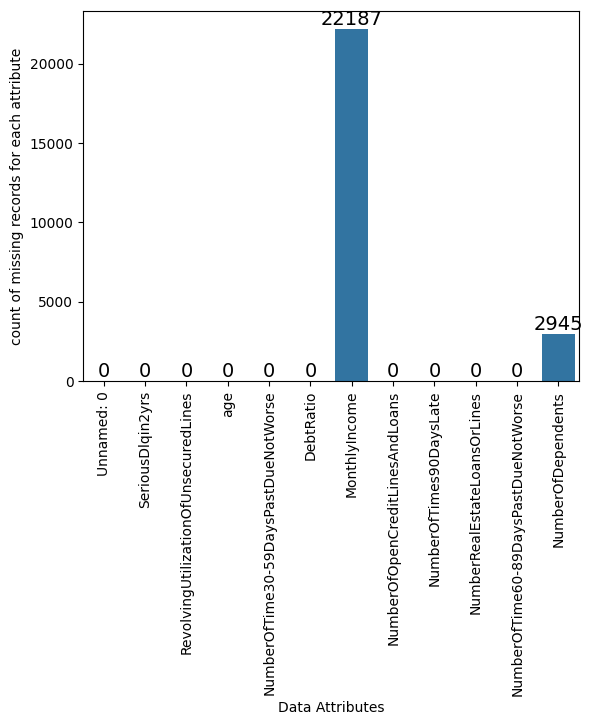

In [138]:
x = df.columns
y = df.isnull().sum()
sns.barplot(x=x, y=y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            int(height),
            fontsize=14, ha='center', va='bottom')
ax.set_xlabel("Data Attributes")
ax.set_ylabel("count of missing records for each attribute")
plt.xticks(rotation=90)
plt.show()

As the graph suggests, the vast majority of missing values are referred to the 'Monthly Income', while there are also some missing values in 'Number of dependents'

Let's compute a calculation the distribution of target labels and their percentages

In [139]:
total_len = len(df['SeriousDlqin2yrs'])
percentage_labels = (df['SeriousDlqin2yrs'].value_counts()/total_len)*100
percentage_labels

SeriousDlqin2yrs
0.0    93.315556
1.0     6.684444
Name: count, dtype: float64

The results indicate a significant data imbalance, with the majority class (0.0) representing approximately 93.32% of the data, while the minority class (1.0) accounts for only about 6.68%. This problem will be addressed.

Now, let's plot the 'SeriousDlqin2yrs' proportions

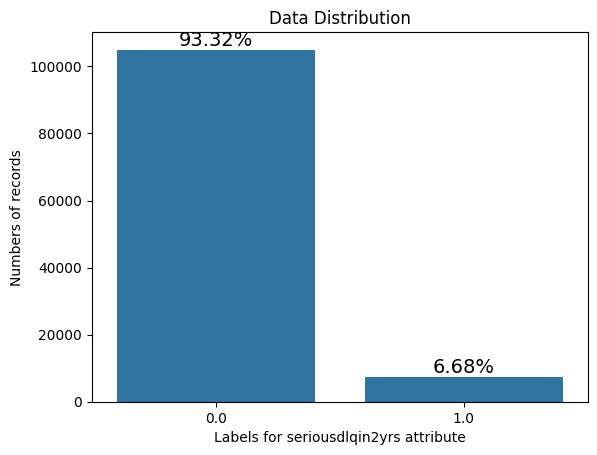

In [140]:
total_len = len(df)  
sns.countplot(data=df, x='SeriousDlqin2yrs').set_title('Data Distribution')
ax = plt.gca()

for p in ax.patches:
    height = p.get_height()  
    ax.text(p.get_x() + p.get_width() / 2.,  
            height + 2,  
            '{:.2f}%'.format(100 * (height / total_len)), 
            fontsize=14, ha='center', va='bottom') 

ax.set_xlabel("Labels for seriousdlqin2yrs attribute")
ax.set_ylabel("Numbers of records")
plt.show()

"If you're over 55 and need a mortgage, the important thing to know if that lenders can't deny you a loan based on your age. But age can factor into your mortgage equation." ([Source](https://www.chicagotribune.com/news/ct-xpm-2005-11-20-0511200488-story.html))

This should be the first concern: making sure we're in legally okay territory. In order to solve this, we need to confirm that in our data set age has a negative influence on probability of defaulting. Then we can assume that the models we build reflect that trend, and won't deny someone a loan simply because they are old. 

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

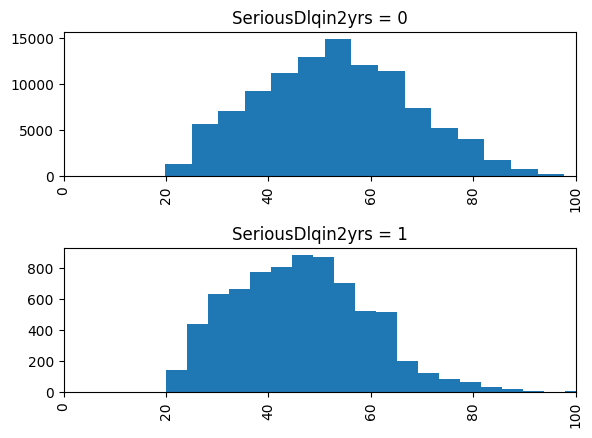

In [141]:
#Visualize the distribution of age for each target class to assess if age has a negative influence on the probability of defaulting
age_hist = df['age'].hist(by=df['SeriousDlqin2yrs'], bins=20, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

Looking at the distribution of people that defaulted vs those who did not indicates that, generally, younger people are more responsible for defaulting.

Let's take a look at our data. We start with Debt Ratio, the ratio of debt to assets:

In [142]:
df.DebtRatio.describe()

count    112500.000000
mean        353.833079
std        2153.220951
min           0.000000
25%           0.175078
50%           0.366299
75%           0.857619
max      329664.000000
Name: DebtRatio, dtype: float64

It is very concerning that someone owes 330,000 times what they own. Maybe that person is a single outlier? Let's take a look:

In [143]:
df.DebtRatio.quantile([.975])

0.975    3488.525
Name: DebtRatio, dtype: float64

Apparently 2.5% of the dataset almost owes more than 3,500 times what they own. We need to investigate to see if these are outliers or not. We can see:

In [144]:
df[df['DebtRatio'] > 3488.525][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,2813.000000,135.000000
mean,0.061145,0.042155
std,0.239638,0.196204
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,0.963116


We see two particularly concerning things here. The first is that of 2,813 records with DebtRatio > 3488.525, only 135 of them have a value for monthly income. Moreover, the people who do have monthly income seem to either have a monthly income of either 1 or 0. We see that: 

In [145]:
df[(df['DebtRatio'] > 3488.525) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome'])].shape[0]

122

...of those 135 entries, 122 of them have the same value for SeriousDlqin2yrs and MonthlyIncome, indicating that there is a data-entry error. 

The second problem is that despite owing thousands of times what they own, these people aren't defaulting any more than the general population. We can conclude that these entries must be data-entry errors, so we will remove them from our model.

In [146]:
general_default_rate = df['SeriousDlqin2yrs'].mean()
high_debt_ratio_default_rate = df[df['DebtRatio'] > 3488.525]['SeriousDlqin2yrs'].mean()

print("Default rate for the general population:", general_default_rate)
print("Default rate for individuals with high debt ratios (> 3488.525):", high_debt_ratio_default_rate)


Default rate for the general population: 0.06684444444444444
Default rate for individuals with high debt ratios (> 3488.525): 0.06114468538926413


In [147]:
df = df[~((df['DebtRatio'] > 3488.525) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome']))]

Now let's take a look at NumberOfTimes90DaysLate:

In [148]:
df.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()

NumberOfTimes90DaysLate
0.0     106085
1.0       3953
2.0       1170
3.0        516
4.0        230
5.0         89
6.0         59
7.0         27
8.0         15
9.0         14
10.0         6
11.0         3
12.0         1
13.0         3
14.0         2
15.0         2
17.0         1
96.0         1
98.0       201
Name: NumberOfTimes90DaysLate, dtype: int64

It is interesting that no one is between 17 and 96 times late, but hundreds of people are 98 times late. We can take a look at these few hundred records:

In [149]:
df[df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,202.000000,202.000000,202.000000,202.000000
mean,0.534653,97.990099,97.990099,97.990099
std,0.500037,0.140720,0.140720,0.140720
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


Somehow, all these (202) people were 30-59 days late 96/98 times, 60-89 days late 96/98 times, and 90+ days late 96/98 times. This is really concerning.  However, the data might not be garbage, because these people are defaulting at a massive rate (53.47%) compared to the population (5%). So we don't want to throw away this data. We can Winsorize by replacing all the 96/98s with 20s to make them not extreme outliers and see if that improves the models. We don't expect that to improve the random forests, which are robust to outliers, but it might improve the SVM (where the decision boundary became more effective at separating the classes, leading to an increase in classification accuracy from slightly better than random to 0.75)

Finally, let's take a look at revolving utilization of unsecured lines. It represents the ratio of money owed to credit limit, so it shouldn't get much above 1. First let's look at values close to 1 and see at what rate they're defaulting. We start with 0.9 to 4.0:

In [150]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > .9) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 4)].SeriousDlqin2yrs.describe()

count    14783.000000
mean         0.224447
std          0.417232
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64

These 14,800 people are defaulting at a rate of almost 1-in-4. This is important! But what about people with more RUUL? Let's consider 4 to 10:

In [151]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 4) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 10)].SeriousDlqin2yrs.describe()

count    17.000000
mean      0.235294
std       0.437237
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

There are only 17 records in this region, but they're still defaulting at a high rate. What about if we go even higher, and consider those with RUUL > 10?

In [152]:
df[df['RevolvingUtilizationOfUnsecuredLines'] > 10].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,131.000000,181.000000,181.000000,181.000000,181.000000,171.000000
mean,54627.193370,0.088398,3693.424130,50.154696,0.204420,623.114483,8229.985523,5.939227,0.099448,1.232044,0.104972,0.695906
std,32348.163272,0.284660,5332.598857,14.249302,0.621094,1953.540200,6768.951285,3.089706,0.667541,1.131013,0.636857,1.018035
min,540.000000,0.000000,11.385230,25.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,26807.000000,0.000000,957.000000,38.000000,0.000000,0.216178,4167.896999,4.000000,0.000000,0.000000,0.000000,0.000000
50%,54901.000000,0.000000,2019.000000,48.000000,0.000000,0.406842,6578.163747,5.000000,0.000000,1.000000,0.000000,0.000000
75%,82667.000000,0.000000,4268.000000,60.000000,0.000000,90.000000,9668.222511,8.000000,0.000000,2.000000,0.000000,1.000000
max,111918.000000,1.000000,50708.000000,86.000000,3.000000,21395.000000,42096.173435,20.000000,8.000000,9.000000,7.000000,4.000000


These 181 people are not defaulting any more than anyone else, despite some of them owing hundreds of thousands of times their credit limits. These seem to be inconsistent with the rest of the data, so we can remove them from our model.

In [153]:
df = df[df['RevolvingUtilizationOfUnsecuredLines'] <= 10]

Finally, let's take a look at using regression to fill in the missing values for MonthlyIncome:

In [154]:
not_missing = df.dropna()
target = 'MonthlyIncome'
predictors = [c for c in list(not_missing) if c not in [target, 'Unnamed: 0','SeriousDlqin2yrs']]
X_data = not_missing[predictors]
y_data = not_missing[target]
regr = LinearRegression().fit(X_data, y_data)

In [155]:
regr.score(X_data, y_data)

0.021635979176825804

This is a terrible $R^2$.\
 It seems that our best bet is to just replace the missing values with the median (instead of the mean, because there are some extreme outliers in MonthlyIncome, who are making millions of dollars a month). The other column with missing values is NumberOfDependents. >50% of the non-missing values have 0 dependents, and if someone leaves the field blank it is likely to be due to not having any dependents, we'll replace these values with 0.

Text(0.5, 1.0, 'Correlation Matrix (HeatMap)')

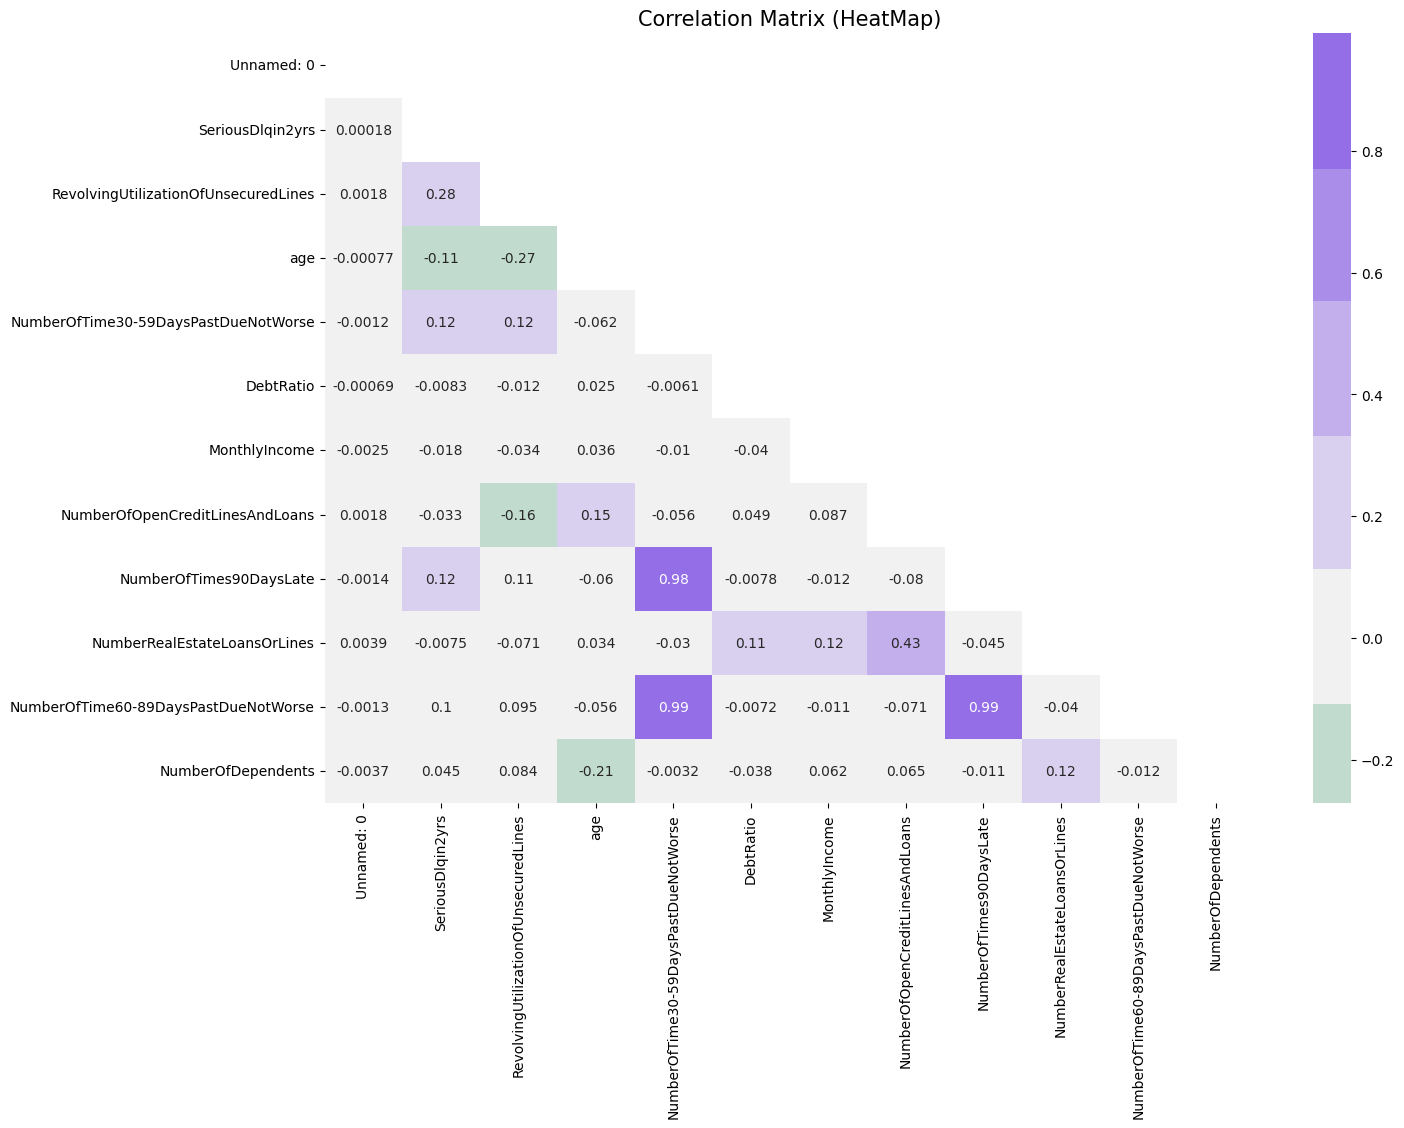

In [156]:
fig = plt.figure(figsize = [15,10])
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), mask = mask, annot=True, center = 0)
plt.title("Correlation Matrix (HeatMap)", fontsize = 15)

## Outliers

### Functions

We try to identify outliers through percentile-based outlier detection, with this method being more flexible in terms of setting the threshold than classical methods like IQR-based method, which is robust to outliers in the data distribution:

In [157]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))

We use then a method which relies on the median and MAD, which are robust measures of central tendency and dispersion, respectively:

In [158]:
def mad_based_outlier(points, threshold=3.5):
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in points]

    return np.abs(modified_z_scores) > threshold

**std_div** performs outlier detection based on the standard deviation of the dataset:

In [159]:
def std_div(data, threshold=3):
    std = data.std()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

The following function combines the results of multiple outlier detection methods and determines outliers based on a voting mechanism:

In [160]:
def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)

    temp = list(zip(x, y, z))  
    final = [False] * len(data)  
    for i, (x_val, y_val, z_val) in enumerate(temp):  
        if [x_val, y_val, z_val].count(True) >= 2:  
            final[i] = True  

    return final

Then it generates a plot to compare different outlier detection methods:

In [161]:
def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.kdeplot(x, ax=ax, color='blue')
        outlier_mask = func(x)  # This should be a boolean array
        outliers = x[outlier_mask]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    titles = ['Percentile-based Outliers', 'MAD-based Outliers', 'STD-based Outliers', 'Majority vote based Outliers']
    for ax, title in zip(axes, titles):
        ax.set_title(title, y=0.95, x=0.05, ha='left', va='top', fontsize=12)
    
    fig.suptitle(f'Comparing Outlier Tests with n={len(x)}', fontsize=20)
    fig.set_size_inches(15, 10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

### Apply functions

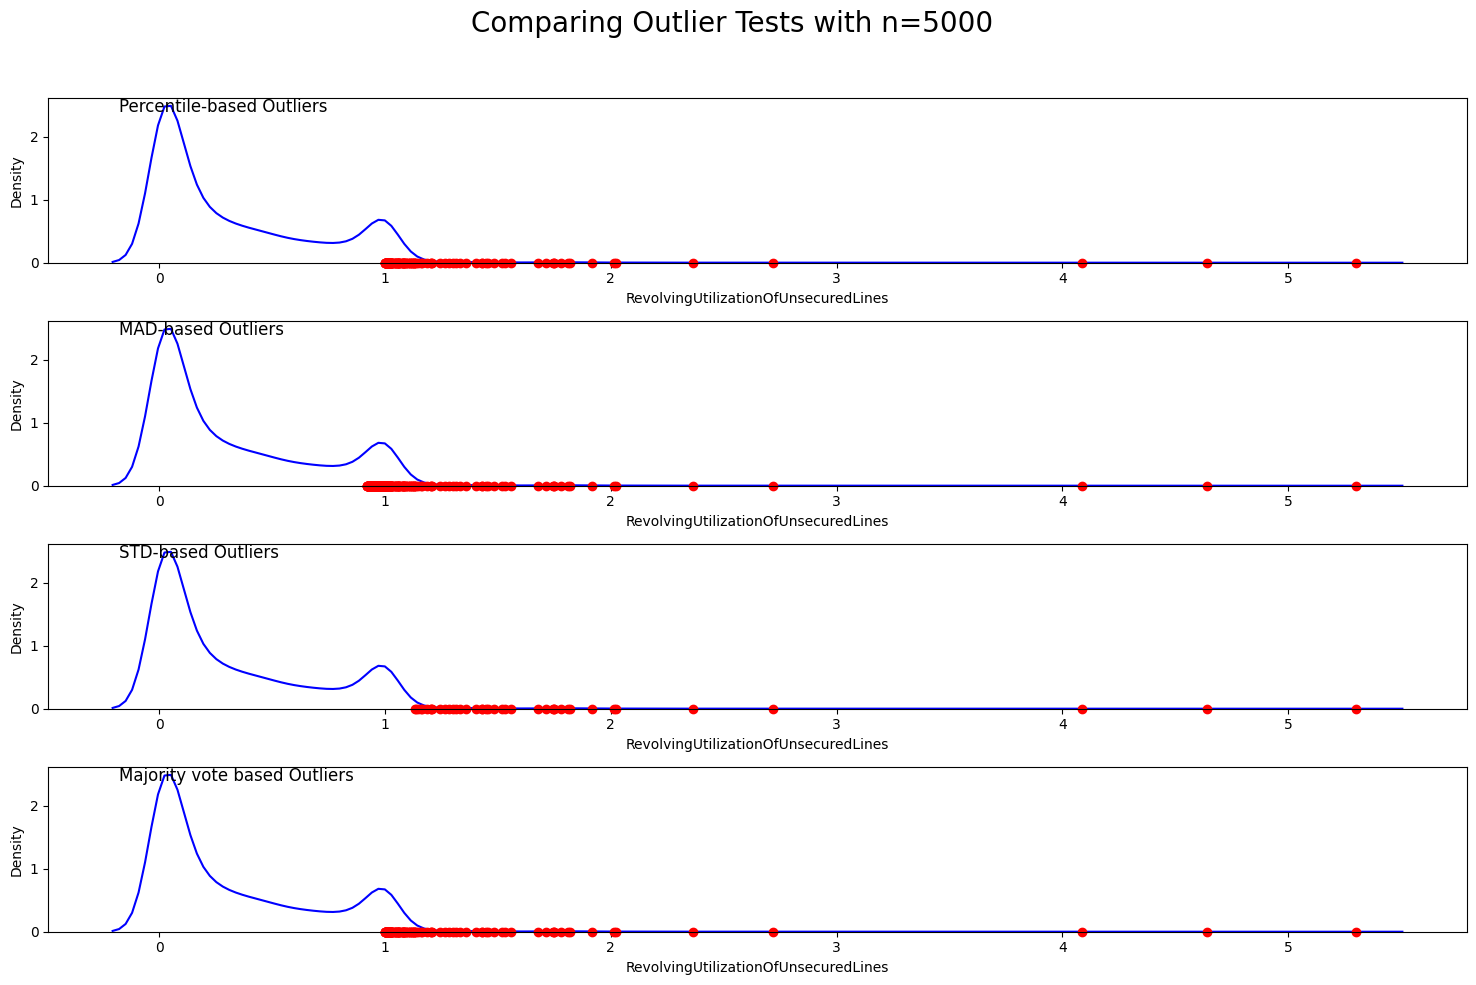

In [162]:
plotOutlier(df.RevolvingUtilizationOfUnsecuredLines.sample(5000))

**Percentile-based Outliers**:
This method likely identifies outliers based on fixed percentile thresholds (e.g., below the 1st percentile or above the 99th percentile). The plot shows a mostly normal distribution with a possible outlier range marked but not clearly shown in this plot. \
**MAD-based Outliers** (Median Absolute Deviation):
The MAD is a robust statistic because it is less sensitive to outliers in the data than the standard deviation. Outliers are points that deviate significantly from the median. In this plot, no specific outliers are marked, but this method would typically identify those points far from the median after scaling by the MAD. \
**STD-based Outliers** (Standard Deviation):
This method identifies outliers based on their distance from the mean, measured in units of standard deviations. In this plot, there's a marked region in red around 1.0 on the x-axis, suggesting that values in this area are considered outliers, likely beyond 2 or 3 standard deviations from the mean. \
**Majority Vote based Outliers:**
This plot suggests a method where multiple outlier detection strategies are used, and points identified as outliers by a majority of these methods are finally labeled as outliers. The plot doesn't show marked outliers, which could mean either there are no clear majority-voted outliers or that they are not visualized in this plot.

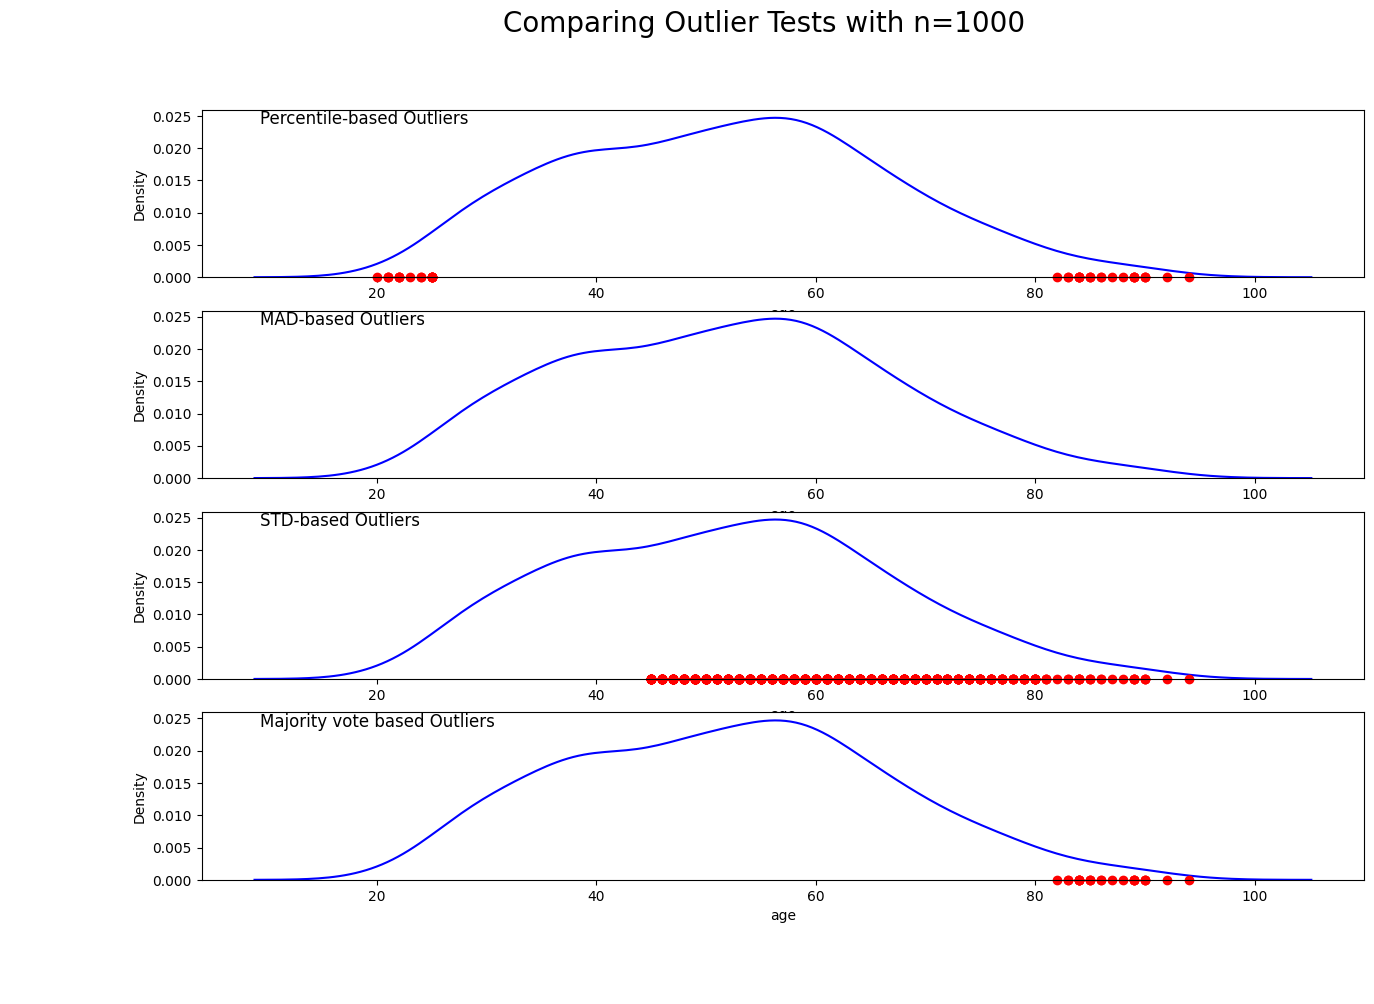

In [163]:
plotOutlier(df.age.sample(1000))

 Now each graph shows the density of a dataset plotted against an "age" variable, with outlier points specifically marked:

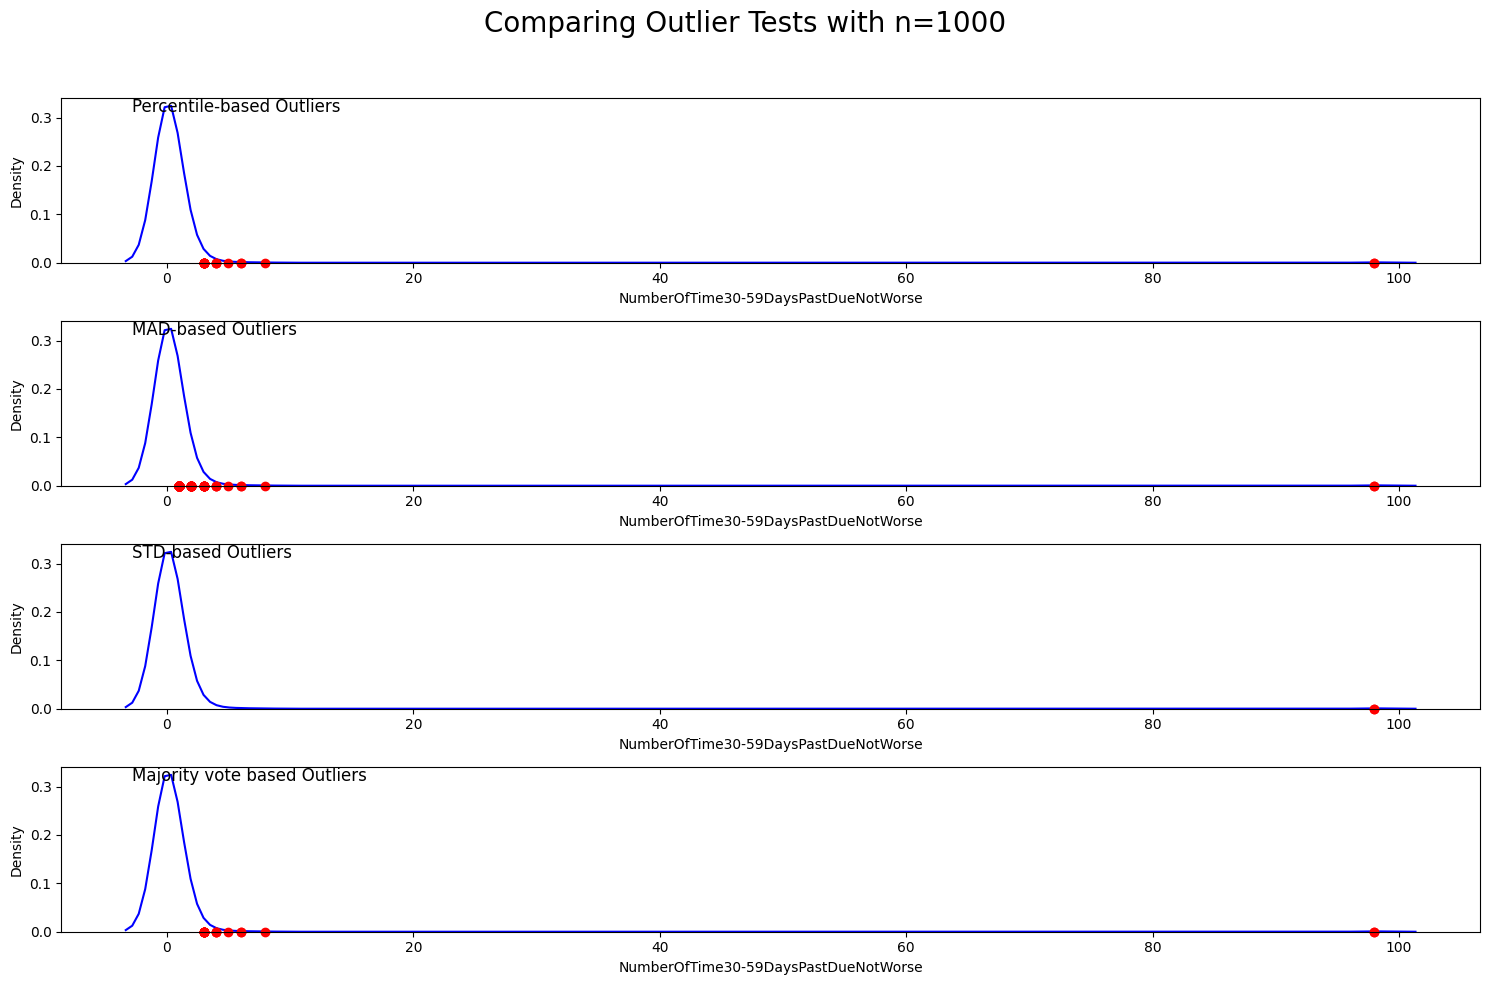

In [164]:
plotOutlier(df["NumberOfTime30-59DaysPastDueNotWorse"].sample(1000))

**Percentile-based Outliers:**
This graph indicates that outliers are being identified based on percentiles. Outliers, shown as red dots, are concentrated toward the higher end of the age spectrum, probably beyond a threshold like the 95th or 99th percentile. This approach often catches extreme values but can ignore context or distribution shape.\
**MAD-based Outliers (Median Absolute Deviation):**
Outliers in this method are not marked, suggesting that no outliers were identified based on the MAD approach. This might occur if the data does not deviate significantly from the median, or if the deviations fit within a typical range when scaled by the MAD. \
**STD-based Outliers** (Standard Deviation):
Similar to the percentile method, the STD-based graph marks numerous high-end values as outliers, located around the same position as the percentile-based method. This indicates that these values are quite distant from the mean in terms of standard deviations, typically beyond 2 or 3 standard deviations. \
**Majority Vote based Outliers:**
This method aggregates results from multiple outlier detection strategies. The marked outliers are exactly the same as those identified in both the percentile and STD-based methods, suggesting a consensus among these approaches about which points are outliers.

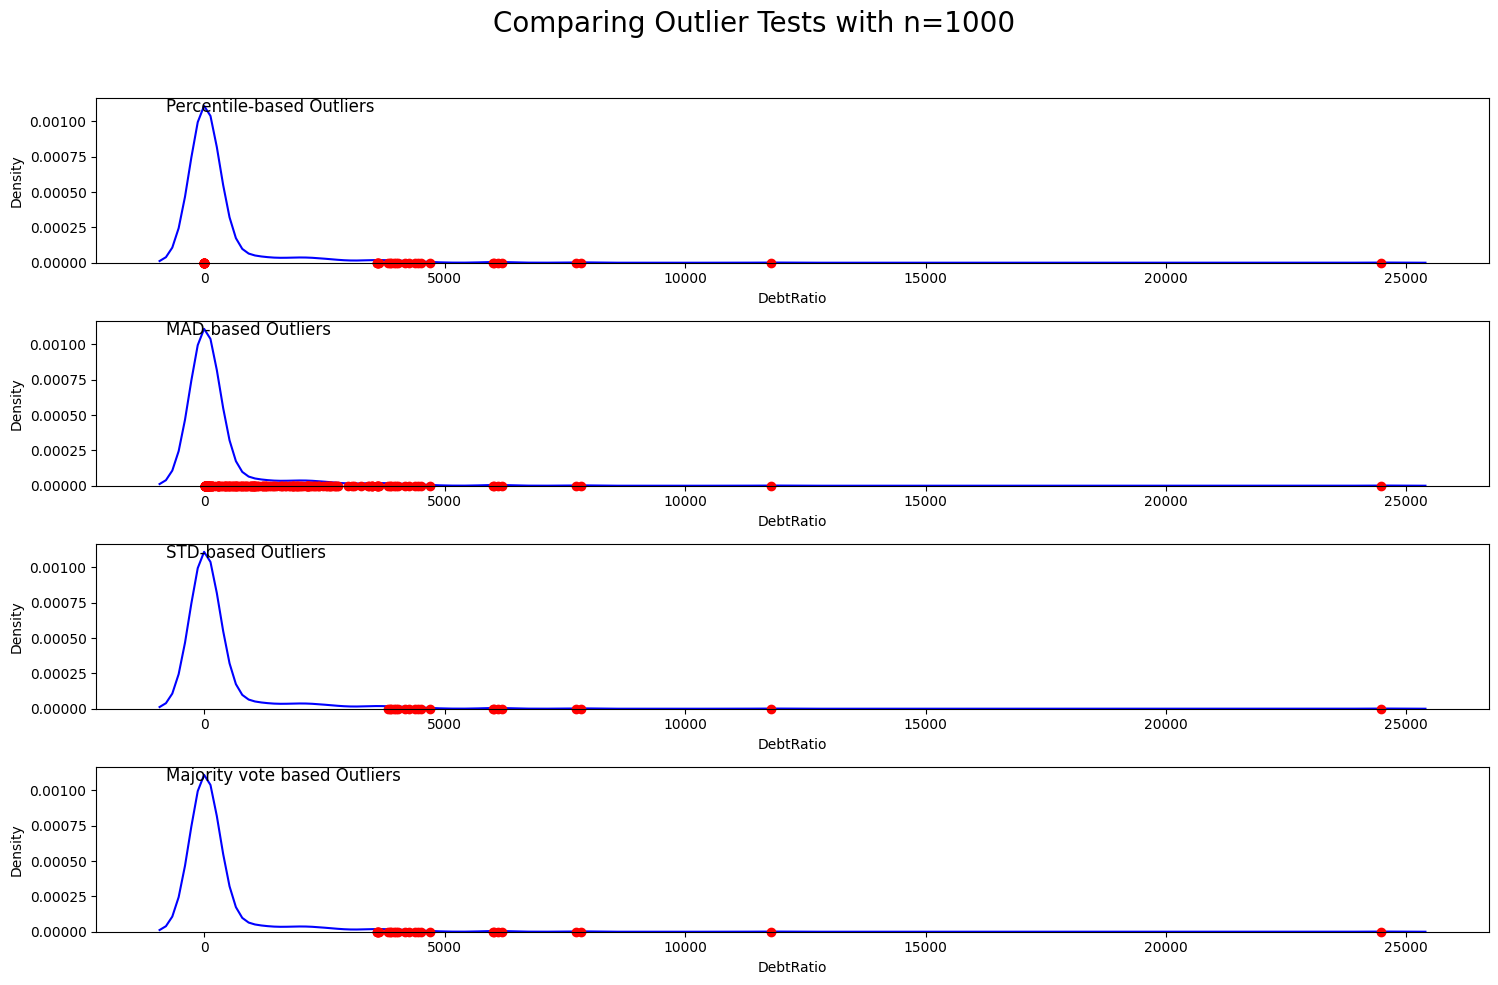

In [165]:
plotOutlier(df.DebtRatio.sample(1000))

**Percentile-based Outliers:**
This plot shows outliers identified based on percentile thresholds. The method flags extreme values, likely outside of a predefined percentile range (e.g., below 1% or above 99%). Here, the red dots represent values considered extreme, mainly on the higher end of the DebtRatio scale.\
**MAD-based Outliers (Median Absolute Deviation):**
This method uses the median and the deviations of data points from this median, adjusted by the MAD, to identify outliers. It's apparent from the plot that similar to the percentile-based approach, only the high-end values are marked as outliers, emphasizing its effectiveness in detecting deviations in a skewed distribution.\
**STD-based Outliers (Standard Deviation):**
Outliers are defined based on how many standard deviations they are from the mean. This approach also identifies high-end extreme values as outliers, similarly to the percentile and MAD-based methods. This consistency across methods suggests these points are significantly distant from the central cluster of data.\
**Majority Vote based Outliers:**
This approach combines findings from several methods and marks an outlier if the majority of the methods agree on it. As seen in the plot, it detects the same high-end outliers as the other three methods, confirming a strong consensus on these extreme values in the DebtRatio distribution.

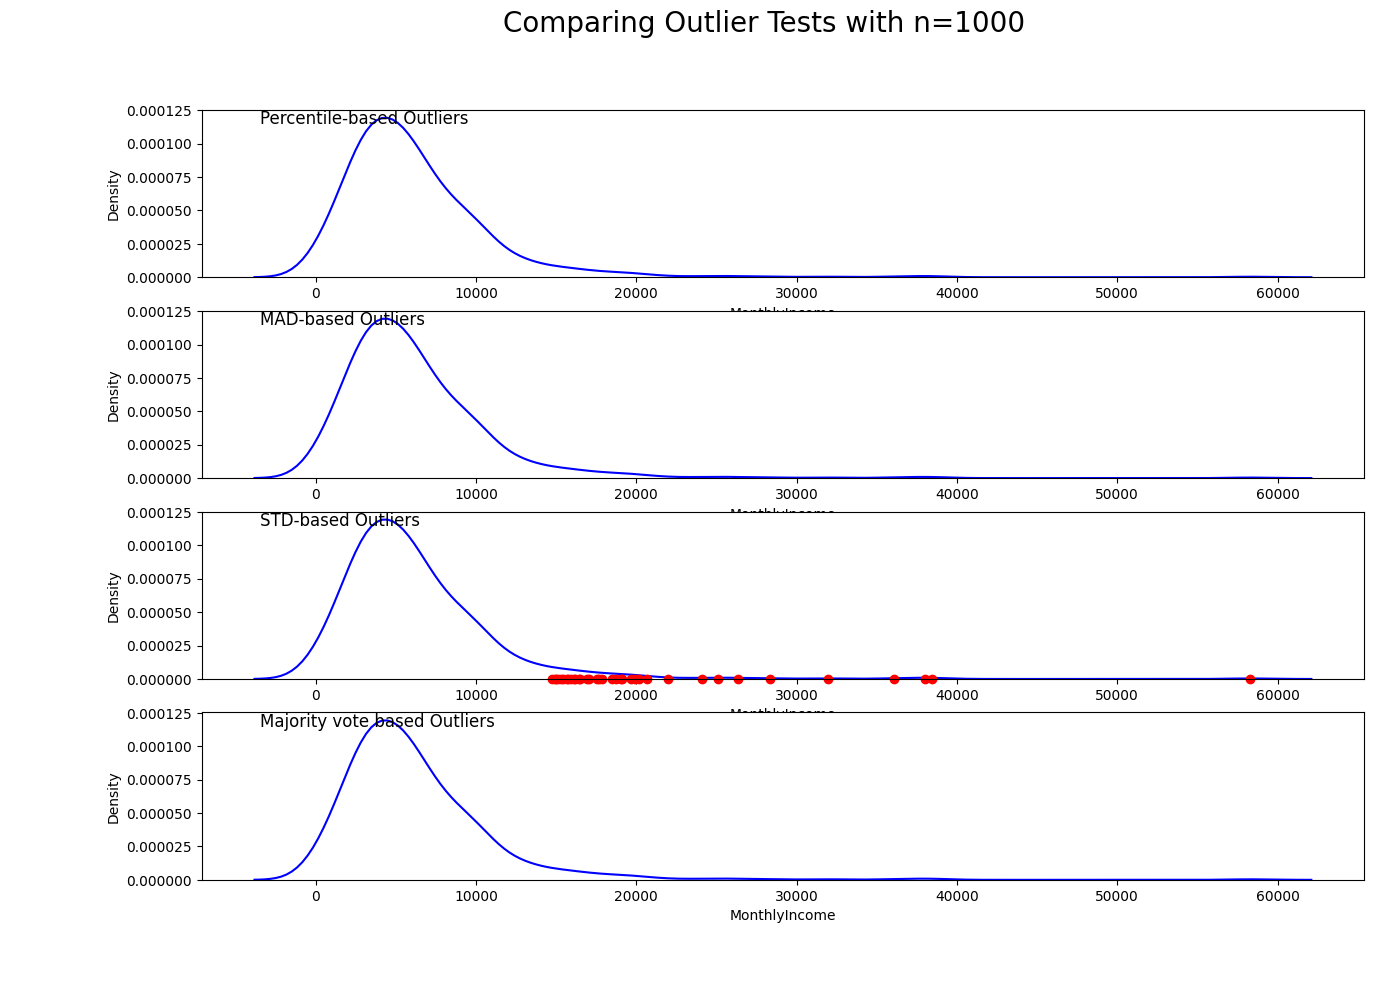

In [166]:
plotOutlier(df.MonthlyIncome.sample(1000))

The consistency between the STD-based and Majority Vote methods in marking the same high-income values as outliers highlights these points as particularly significant deviations from the norm. The absence of marked outliers in the percentile and MAD-based methods may indicate these values aren't as extreme relative to the distribution's range or median but are significant when compared to the mean and overall variance.

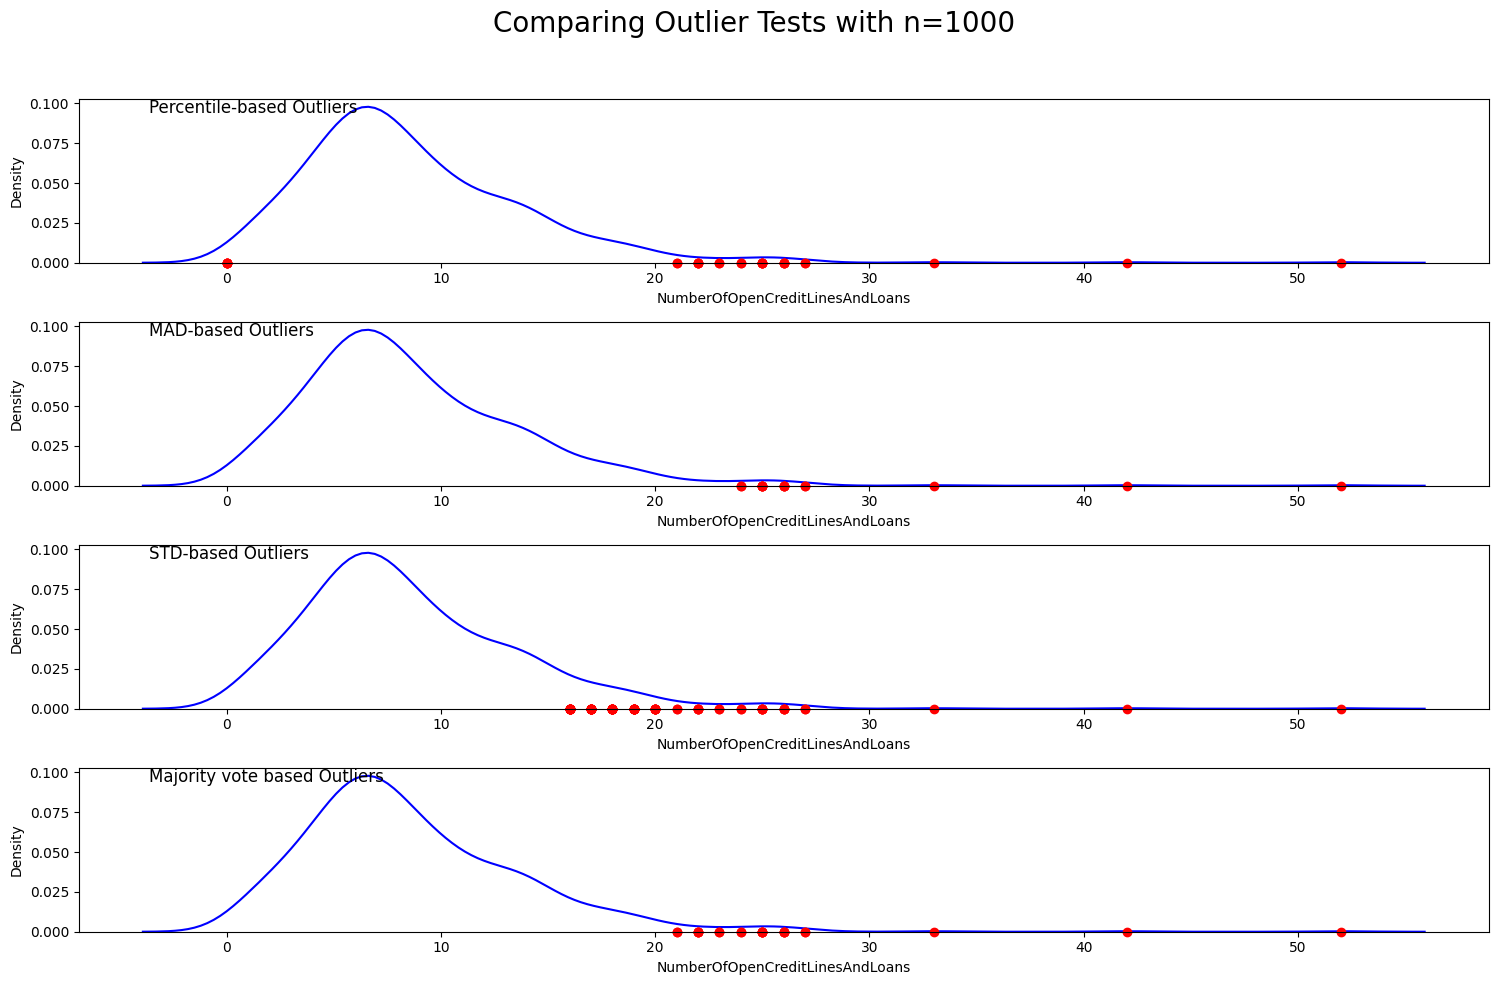

In [167]:
plotOutlier(df.NumberOfOpenCreditLinesAndLoans.sample(1000))

**Percentile-based Outliers:**
Outliers are only identified at the higher end, suggesting that unusually high counts of credit lines and loans are considered abnormal. Low counts, even if sparse, aren't flagged, indicating the method's sensitivity to upper extremes.\
**MAD-based Outliers:**
Like the percentile-based approach, the MAD-based method highlights outliers predominantly on the upper range. This indicates that deviations from the median on the higher side are significant enough to be flagged.\
**STD-based Outliers:**
This method flags a broad range of high values as outliers, showing sensitivity to extremes far from the mean. It highlights a gradual increase in outlier identification as values increase, suggesting a wider acceptance of lower values as 'normal'.\
**Majority Vote based Outliers:**
Reflects a consensus mainly on the highest values, integrating findings from multiple methods. This approach confirms the upper extreme values as significant outliers, consistent with the observations from other methods.

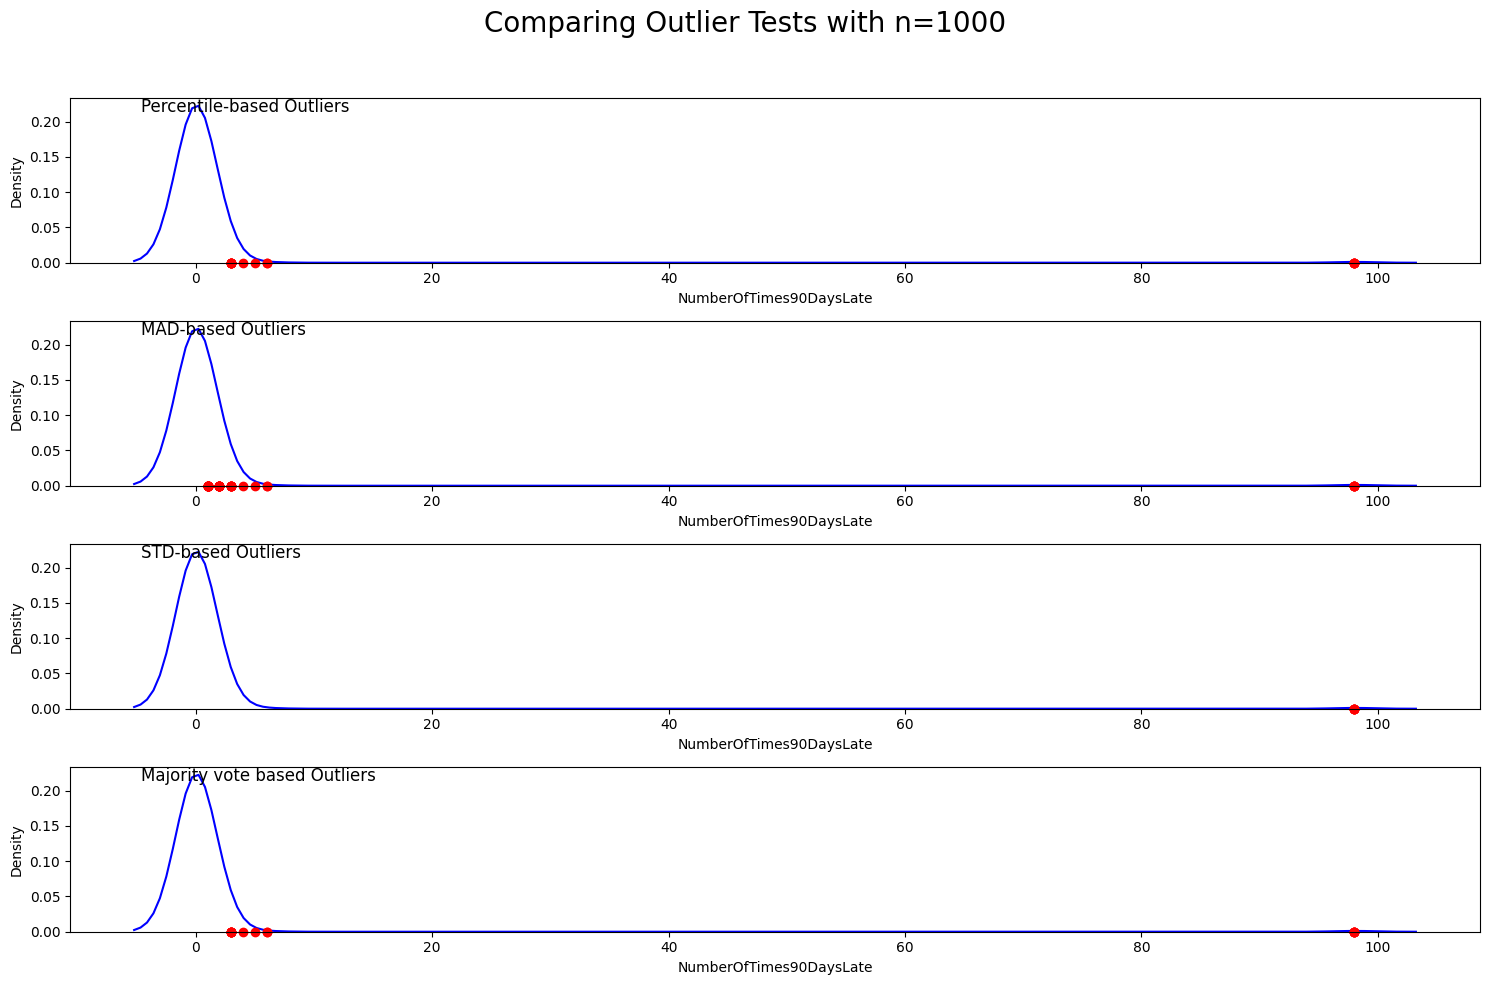

In [168]:
plotOutlier(df.NumberOfTimes90DaysLate.sample(1000))

**Percentile-based Outliers:**
A few extreme low-end values and several very high values are identified as outliers. This suggests a sensitivity to values both significantly below and above the typical range.\
**MAD-based Outliers:**
Similar to the percentile-based method, it marks multiple low-end and a few high-end values as outliers. This highlights that deviations from the median, adjusted by the Median Absolute Deviation, are significant.\
**STD-based Outliers:**
This method primarily flags high-end values, identifying fewer outliers compared to the other methods but focusing on the most extreme cases in the upper range.\
**Majority Vote based Outliers:**
Shows a consensus on several lower-end and extreme higher-end values, emphasizing these as the most significant outliers across the methods used.


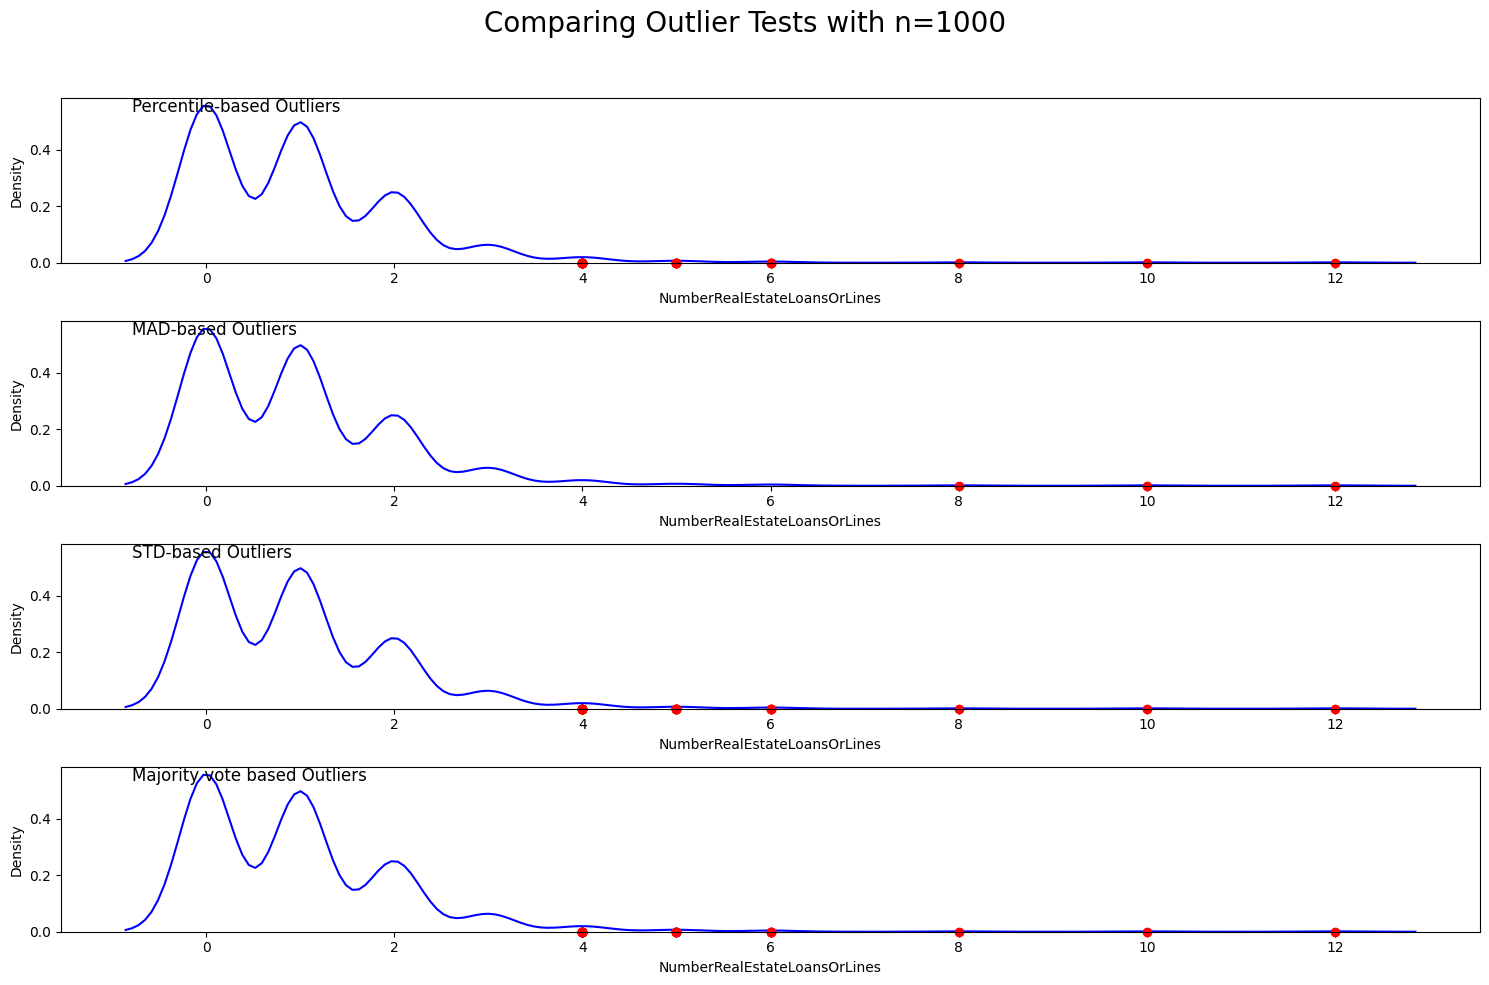

In [169]:
plotOutlier(df.NumberRealEstateLoansOrLines.sample(1000))

**Percentile-based Outliers:**
This method identifies outliers mainly on the higher end, suggesting that an unusually high number of real estate loans or lines are considered outliers. This reflects the approach's sensitivity to extreme upper values.\
**MAD-based Outliers:**
Similar to the percentile method, this approach also flags high values as outliers, indicating significant deviations from the median of the distribution. It highlights that values are outliers based on a robust measure of variability.\
**STD-based Outliers:**
This method identifies fewer outliers compared to the MAD and percentile methods, focusing only on the extreme upper values. It suggests that only the most statistically significant deviations from the mean are considered outliers.\
**Majority Vote based Outliers:**
Shows a similar trend to the STD-based method, marking fewer data points as outliers and focusing only on the upper extremes. This method combines multiple approaches and highlights those points most consistently considered outliers.

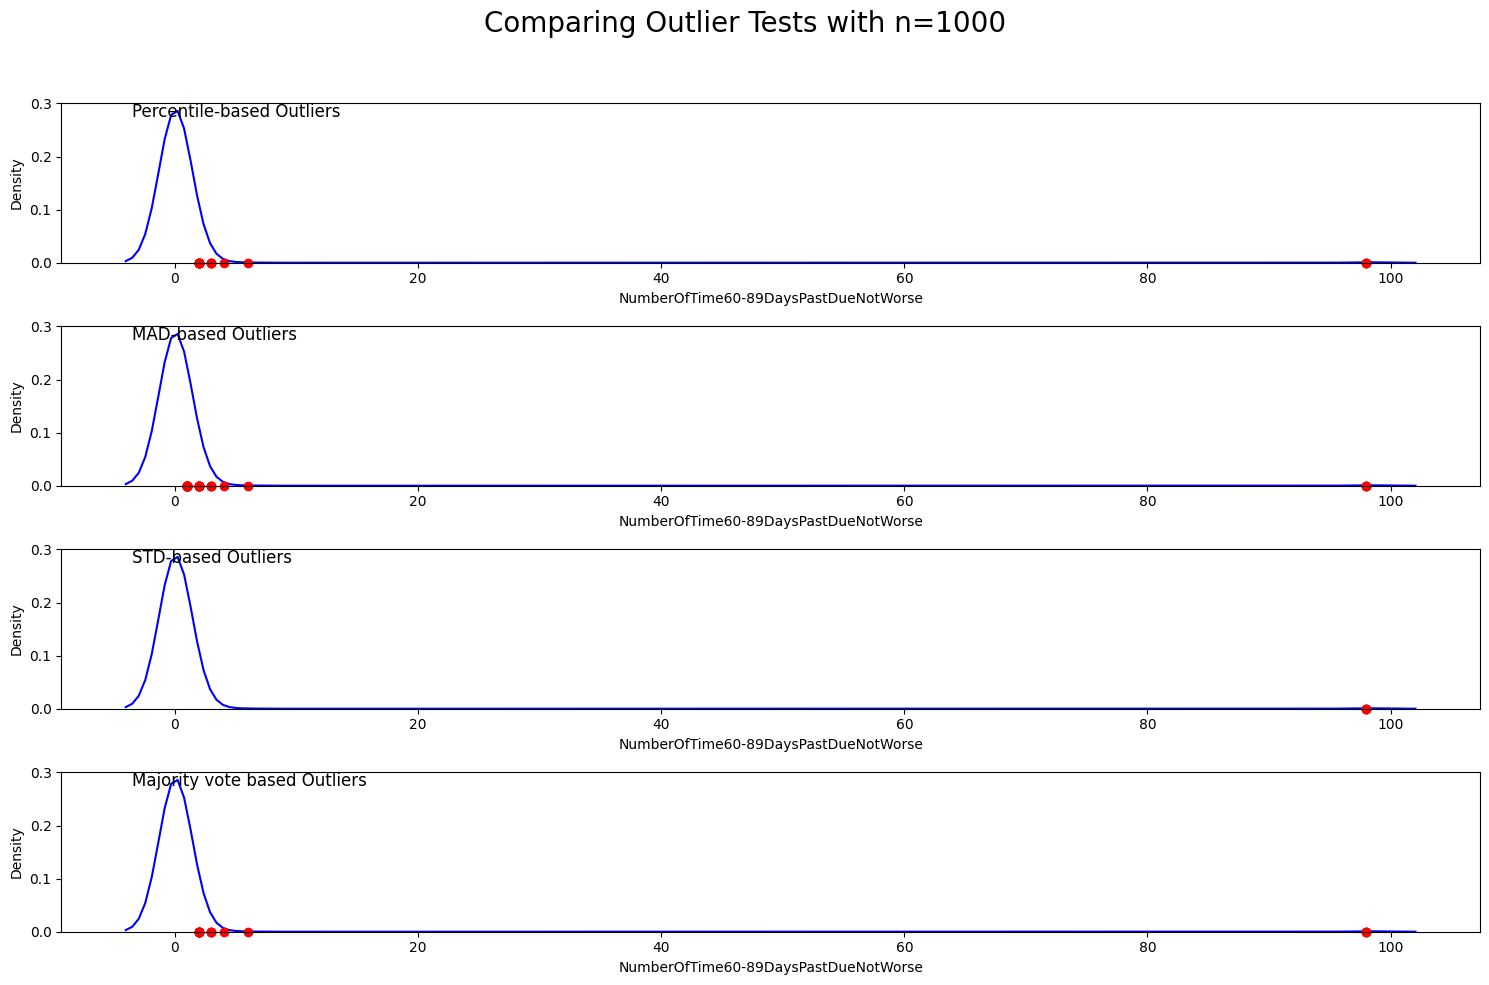

In [170]:
plotOutlier(df["NumberOfTime60-89DaysPastDueNotWorse"].sample(1000))

**Percentile-based Outliers:**
This method detects several low-end outliers, and a number of high-end outliers far removed from the main distribution. It shows a sensitivity to values both significantly below and above the central data cluster.\
**MAD-based Outliers:**
Similar to the percentile-based method, the MAD-based method identifies low-end values as outliers. This suggests these values are significant deviations from the median, highlighting unusual occurrences in terms of late payments.
**STD-based Outliers:**
Focusing on high-end values, this method identifies the most extreme cases as outliers. These are well beyond the typical range of data, suggesting that such high values are rare and significantly distant from the mean.\
**Majority Vote based Outliers:**
This method marks similar points as the STD-based and MAD-based methods, indicating agreement on the most significantly deviating low and high values. This consensus underscores the importance of these outliers in analyses involving credit behavior.

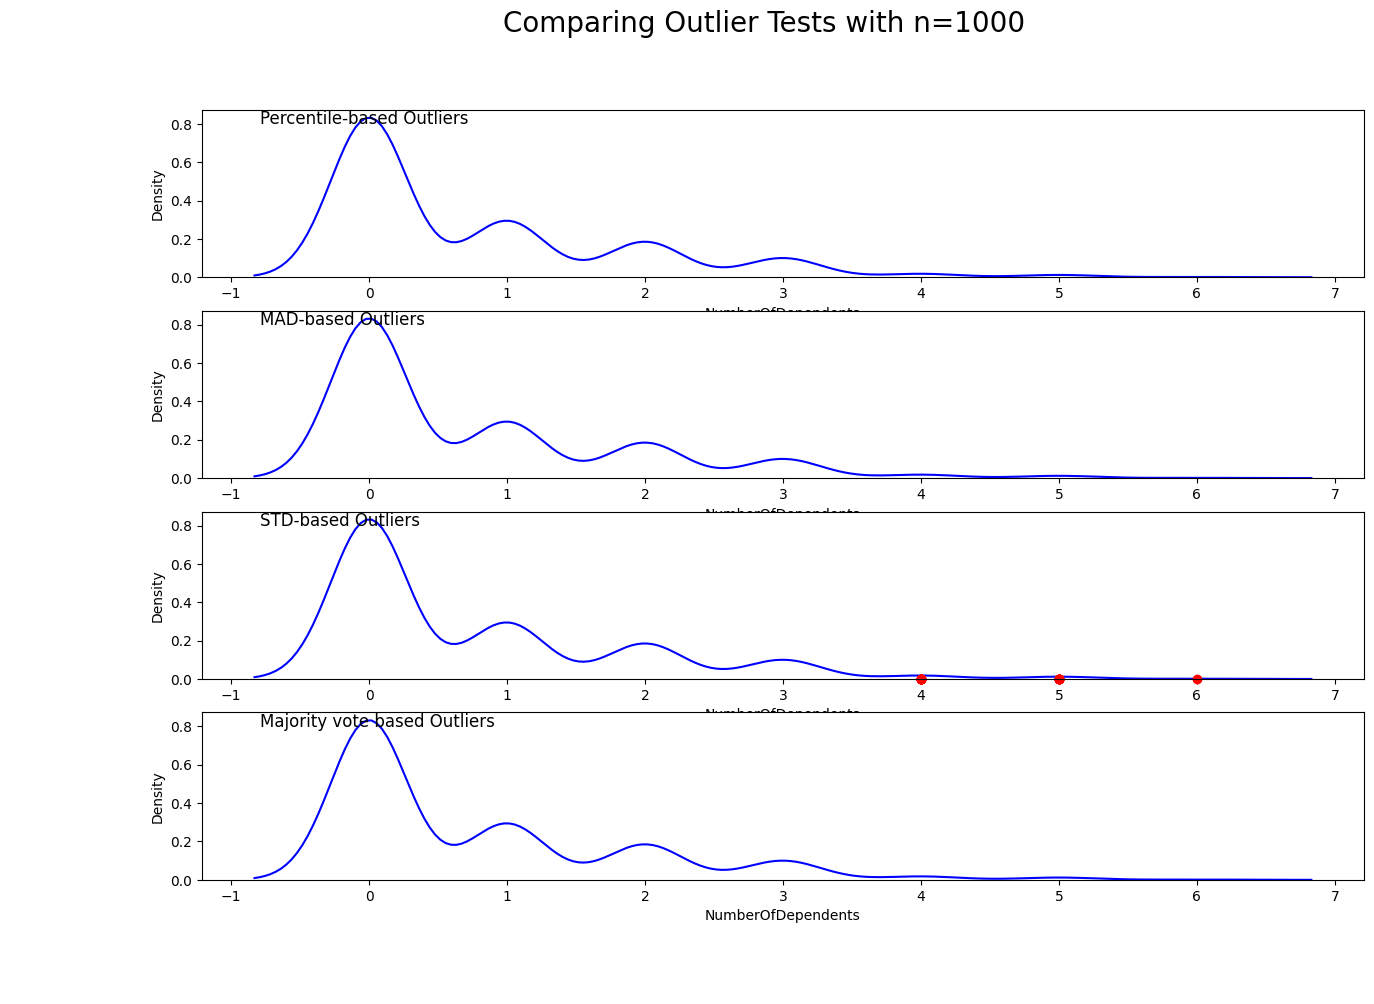

In [171]:
plotOutlier(df.NumberOfDependents.sample(1000))

**Percentile-based Outliers:**
This plot shows a clear bell-shaped distribution with no outliers marked, suggesting that all values fall within a typical range based on percentile thresholds.\
**MAD-based Outliers:**
Similar to the percentile-based method, no outliers are marked in this plot. The data seems to cluster around a central value, indicating a relatively consistent number of dependents among most observations.\
**STD-based Outliers:**
This method identifies outliers only at the higher end, marking values as outliers when the number of dependents is unusually high compared to the mean. These outliers likely fall beyond a certain number of standard deviations from the mean.\
**Majority Vote based Outliers:**
The majority vote method also marks high values as outliers, aligning with the standard deviation method. This suggests a consensus that unusually high numbers of dependents are significant deviations from the norm.

### Handling outliers

We limit the values in the 'RevolvingUtilizationOfUnsecuredLines' column to a maximum of 0.99999 to prevent potential data outliers or anomalies from skewing the analysis:


In [172]:
revNew = []
df.RevolvingUtilizationOfUnsecuredLines
for val in df.RevolvingUtilizationOfUnsecuredLines:
    if val <= 0.99999:
        revNew.append(val)
    else:
        revNew.append(0.99999)
df.RevolvingUtilizationOfUnsecuredLines = revNew

<Axes: >

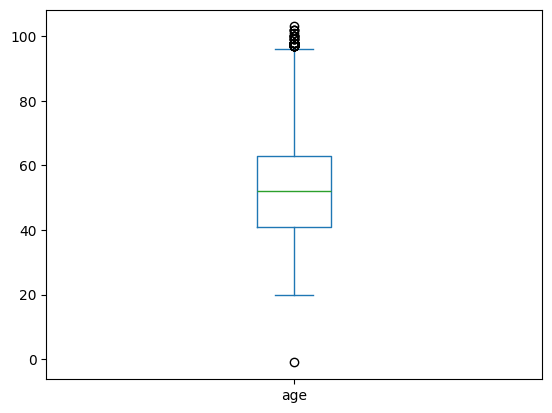

In [173]:
df.age.plot.box()

In [174]:
import collections
collections.Counter(df.age)

Counter({48.0: 2862,
         49.0: 2853,
         50.0: 2803,
         47.0: 2753,
         51.0: 2734,
         46.0: 2708,
         52.0: 2701,
         55.0: 2688,
         62.0: 2685,
         54.0: 2654,
         53.0: 2651,
         57.0: 2647,
         45.0: 2596,
         56.0: 2582,
         63.0: 2544,
         61.0: 2530,
         59.0: 2527,
         60.0: 2501,
         64.0: 2490,
         58.0: 2469,
         44.0: 2458,
         42.0: 2420,
         43.0: 2358,
         41.0: 2291,
         40.0: 2265,
         39.0: 2162,
         65.0: 2149,
         38.0: 2008,
         66.0: 1935,
         37.0: 1886,
         36.0: 1779,
         67.0: 1741,
         35.0: 1660,
         68.0: 1629,
         34.0: 1629,
         32.0: 1586,
         69.0: 1552,
         33.0: 1546,
         31.0: 1478,
         30.0: 1381,
         70.0: 1362,
         71.0: 1298,
         29.0: 1295,
         72.0: 1203,
         73.0: 1173,
         28.0: 1083,
         74.0: 1064,
         27.0

Then we perform an outlier removal:

In [175]:
ageNew = []
for val in df.age:
    if val > 18:
        ageNew.append(val)
    else:
        ageNew.append(18)
        
df.age = ageNew

Verifying again with the collections  method:

In [176]:
collections.Counter(df["NumberOfTime30-59DaysPastDueNotWorse"])

Counter({0.0: 94208,
         1.0: 12059,
         2.0: 3437,
         3.0: 1322,
         4.0: 534,
         5.0: 252,
         98.0: 201,
         6.0: 104,
         7.0: 41,
         8.0: 22,
         9.0: 8,
         10.0: 4,
         12.0: 2,
         11.0: 1,
         13.0: 1,
         96.0: 1})

Again, an outlier removal:

In [177]:
New = []
med = df["NumberOfTime30-59DaysPastDueNotWorse"].median()
for val in df["NumberOfTime30-59DaysPastDueNotWorse"]:
    if ((val == 98) | (val == 96)):
        New.append(med)
    else:
        New.append(val)

df["NumberOfTime30-59DaysPastDueNotWorse"] = New

Now we evaluate and quantify outliers in a dataset using various outlier detection methods. Each method returns a list of boolean values where True indicates an outlier.

In [178]:
def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict
outlierRatio(df.DebtRatio)

{'percentile_based_outlier': [2803, '2.50%'],
 'mad_based_outlier': [23468, '20.92%'],
 'std_div': [492, '0.44%'],
 'outlierVote': [2803, '2.50%']}

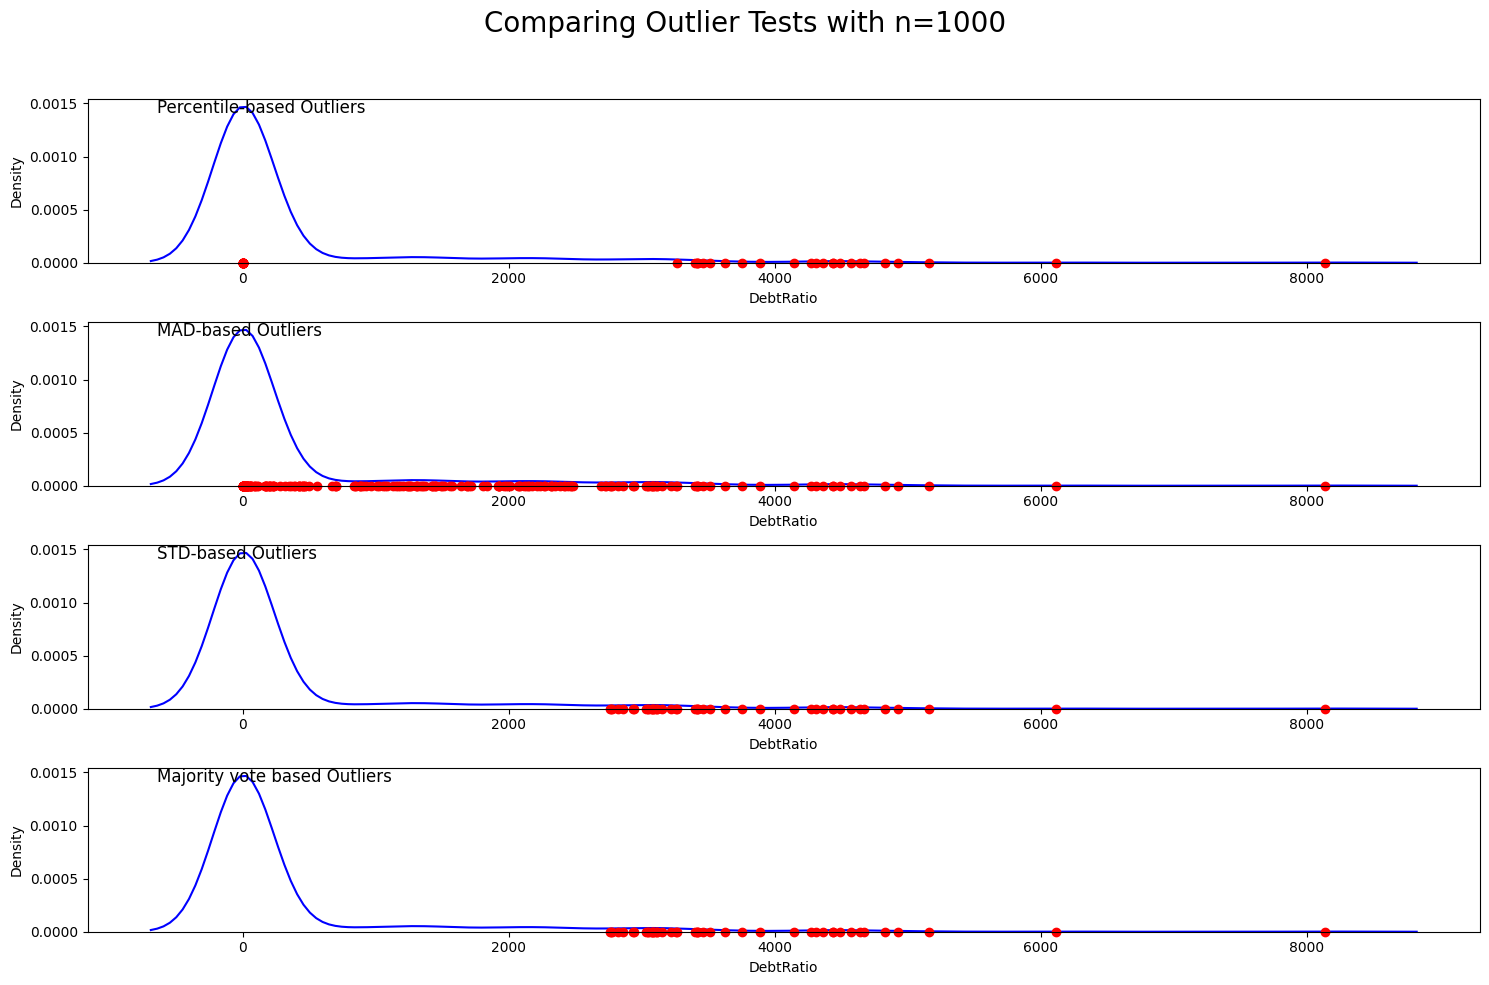

In [179]:
plotOutlier(df.DebtRatio.sample(1000))

The consistency of outlier identification in high values across the MAD-based, STD-based, and Majority Vote methods suggests that the DebtRatio variable has a significant number of high-value outliers, which might indicate financial stress or data entry errors.\
The lack of outliers detected by the Percentile-based method could suggest that the data does not have extreme values that fall beyond typical statistical thresholds, or that its distribution is skewed such that high values are still within the top percentiles.


In [180]:
df[df['DebtRatio'] < 1]


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.0,0.034949,59.0,0.0,0.004933,7959.688894,5.0,0.0,0.0,0.0,0.0
2,2,0.0,0.165166,62.0,1.0,0.020327,2851.722407,8.0,0.0,0.0,0.0,0.0
3,3,0.0,0.010886,61.0,0.0,0.642979,1115.657341,6.0,0.0,1.0,0.0,0.0
6,6,0.0,0.030666,57.0,0.0,0.180106,7326.774822,4.0,0.0,1.0,0.0,0.0
7,7,0.0,0.189005,42.0,1.0,0.264385,13722.437571,18.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
112492,112492,0.0,0.055431,44.0,0.0,0.370023,8560.019993,17.0,0.0,1.0,0.0,3.0
112493,112493,0.0,0.000000,62.0,0.0,0.000000,3596.193235,2.0,0.0,0.0,0.0,0.0
112495,112495,0.0,0.008277,59.0,0.0,0.252965,6829.298430,5.0,0.0,2.0,0.0,0.0
112496,112496,0.0,0.054864,53.0,1.0,0.506413,4591.184178,8.0,0.0,1.0,0.0,2.0


The graph displays the distribution of DebtRatio using a logarithmic scale, indicating most values cluster at the lower end, with frequency drastically decreasing as values increase. This visualization highlights the right-skewed nature of the data, where lower DebtRatio values are more common, and very high ratios are rare. The dual y-axes show both the percentage and the actual count of data points in each bin, effectively summarizing the dataset's spread.

In [181]:
minUpperBound = min([val for (val, out) in zip(df.DebtRatio, mad_based_outlier(df.DebtRatio)) if out == True])

In [182]:
newDebtRatio = []
for val in df.DebtRatio:
    if val > minUpperBound:
        newDebtRatio.append(minUpperBound)
    else:
        newDebtRatio.append(val)

df.DebtRatio = newDebtRatio 

In [183]:
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        tfOutlier = list(zip(x, func(x)))  # Convert to list to use multiple times
        outliers = [value for (value, bol) in tfOutlier if bol]  # Get values where bol is True
        non_outliers = [value for (value, bol) in tfOutlier if not bol]  # Get values where bol is False
        nOutliers.append(len(outliers))
        
        if non_outliers:  # Check if non_outliers is not empty
            sns.kdeplot(non_outliers, ax=ax, color='blue')  # Plot non-outliers
            sns.rugplot(non_outliers, ax=ax, color='red')  # Add a rug plot for non-outliers
        else:
            ax.text(0.5, 0.5, 'No data to display', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
    titles = ['Percentile-based Outliers, removed: {}', 'MAD-based Outliers, removed: {}', 'STD-based Outliers, removed: {}', 'Majority vote based Outliers, removed: {}']
    for ax, title, n in zip(axes, titles, nOutliers):
        ax.set_title(title.format(n), y=0.95, x=0.05, ha='left', va='top', size=15)
    
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig.set_size_inches(15, 10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

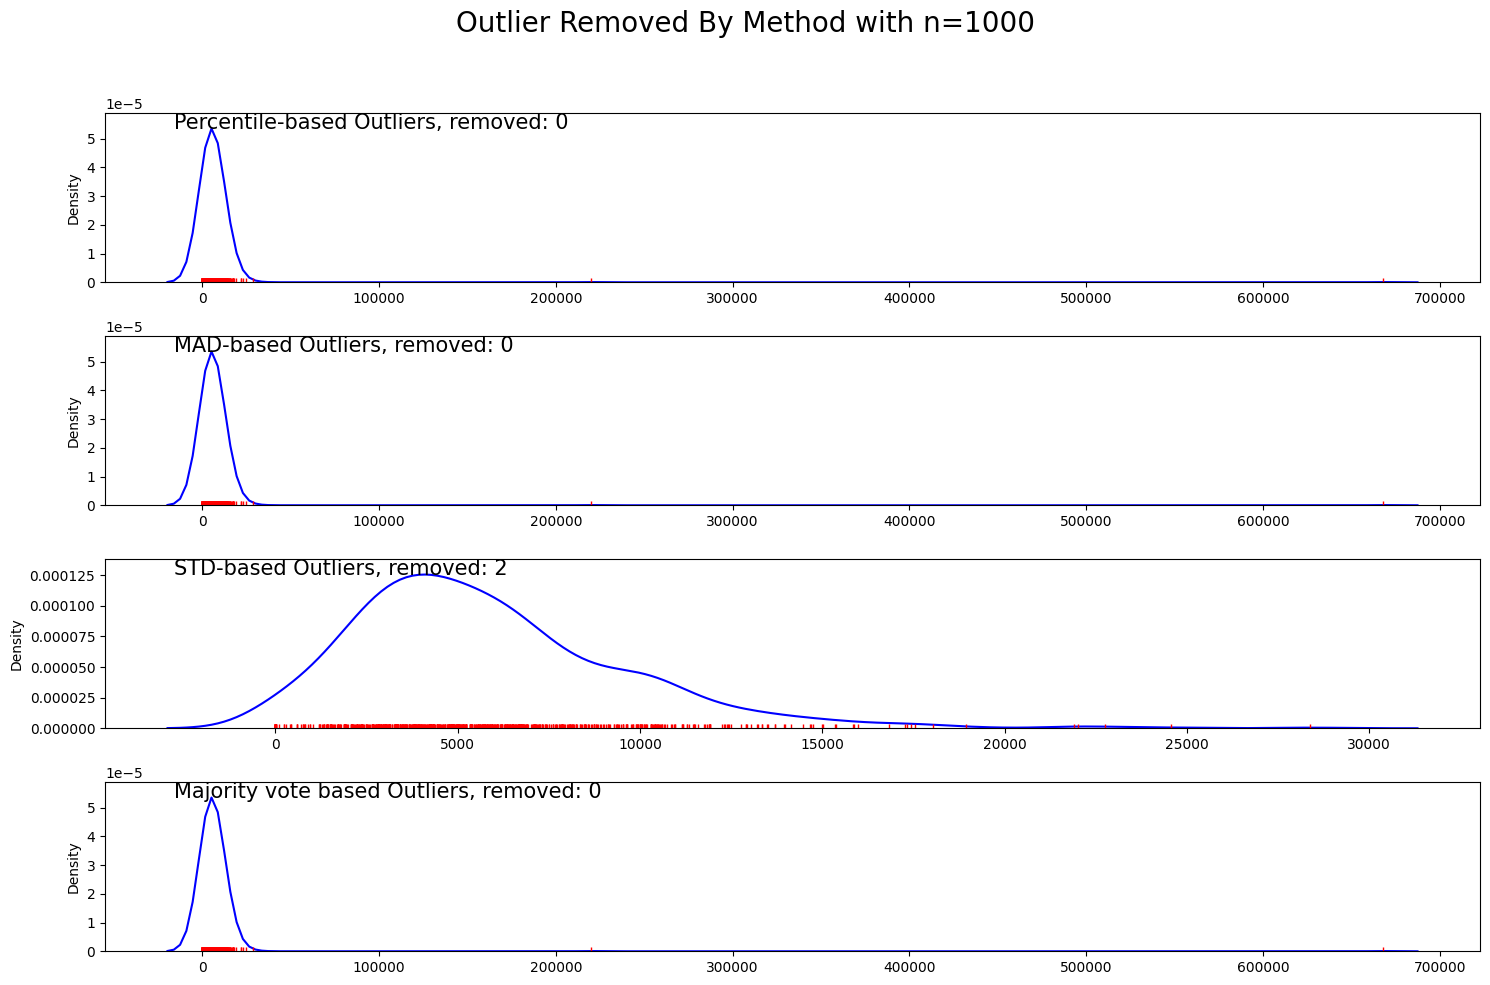

In [184]:
plotOutlierFree(df.MonthlyIncome.sample(1000))

The graph visually demonstrates the distribution of outlier identification in the DebtRatio variable, highlighting the proportion of outliers relative to the rest of the dataset.
The tall outlier bar suggests that a significant portion of the DebtRatio values are considered outliers by the MAD-based method, indicating a notable presence of extreme values in the dataset.
Conversely, the shorter non-outlier bar indicates that the majority of the DebtRatio values fall within the typical range and are not considered outliers.

In the following lines of code we will additionally clean our data from outliers: 

In [185]:
#We replace outliers using a specified outlier detection method which transforms them with the median value or the minimum upper bound of the outlier detection:
def replaceOutlier(data, method, replace='median'):
    vote = method(data)
    x = pd.DataFrame(zip(data, vote), columns=['debt', 'outlier'])
    
    if replace == 'median':
        replacement_value = x.debt.median()
    elif replace == 'minUpper':
        outlier_values = [val for (val, is_outlier) in zip(data, vote) if is_outlier]
        
        if not outlier_values:  
            return list(data)
        
        replacement_value = min(outlier_values)
        
        if replacement_value < data.mean():
            raise ValueError('The minimum outlier value is lower than the sample mean.')
    
    # Replace outliers
    debtNew = [replacement_value if is_outlier else val for val, is_outlier in zip(x.debt, x.outlier)]
    
    return debtNew


In [186]:
#Outliers are replaced with the minimum upper bound of the outlier detection
df.MonthlyIncome = replaceOutlier(df['MonthlyIncome'], method=outlierVote, replace='minUpper')

In [187]:
collections.Counter(df.NumberOfTimes90DaysLate)

Counter({0.0: 105912,
         1.0: 3948,
         2.0: 1169,
         3.0: 515,
         4.0: 230,
         98.0: 201,
         5.0: 89,
         6.0: 59,
         7.0: 27,
         9.0: 14,
         8.0: 14,
         10.0: 6,
         13.0: 3,
         11.0: 3,
         15.0: 2,
         14.0: 2,
         96.0: 1,
         12.0: 1,
         17.0: 1})

In [188]:
def removeSpecificAndPutMedian(data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val)
            
    return New

In [189]:
df.NumberOfTimes90DaysLate = removeSpecificAndPutMedian(df.NumberOfTimes90DaysLate)

In [190]:
collections.Counter(df.NumberRealEstateLoansOrLines)

Counter({0.0: 42074,
         1.0: 39152,
         2.0: 23567,
         3.0: 4686,
         4.0: 1597,
         5.0: 527,
         6.0: 243,
         7.0: 134,
         8.0: 69,
         9.0: 50,
         10.0: 26,
         11.0: 19,
         13.0: 12,
         12.0: 11,
         15.0: 5,
         14.0: 5,
         17.0: 3,
         25.0: 3,
         16.0: 3,
         19.0: 2,
         23.0: 2,
         18.0: 2,
         32.0: 1,
         21.0: 1,
         54.0: 1,
         20.0: 1,
         26.0: 1})

In [191]:
realNew = []
for val in df.NumberRealEstateLoansOrLines:
    if val > 17:
        realNew.append(17)
    else:
        realNew.append(val)
df.NumberRealEstateLoansOrLines = realNew

In [192]:
collections.Counter(df["NumberOfTime30-59DaysPastDueNotWorse"])

Counter({0.0: 94410,
         1.0: 12059,
         2.0: 3437,
         3.0: 1322,
         4.0: 534,
         5.0: 252,
         6.0: 104,
         7.0: 41,
         8.0: 22,
         9.0: 8,
         10.0: 4,
         12.0: 2,
         11.0: 1,
         13.0: 1})

In [193]:
df["NumberOfTime30-59DaysPastDueNotWorse"] = removeSpecificAndPutMedian(df["NumberOfTime30-59DaysPastDueNotWorse"])

In [194]:
collections.Counter(df.NumberOfDependents)

Counter({0.0: 64936,
         1.0: 19780,
         2.0: 14593,
         3.0: 7058,
         4.0: 2160,
         5.0: 553,
         6.0: 119,
         7.0: 38,
         8.0: 17,
         10.0: 4,
         9.0: 3,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
      

In [195]:
depNew = []
for var in df.NumberOfDependents:
    if var > 10:
        depNew.append(10)
    else:
        depNew.append(var)

In [196]:
df.NumberOfDependents = depNew

## Feature Engineering

Now we try to add some addition feature to our dataset, creating new ones, to see if it is possible to create an environment better to run the models. 
We will see in the session 'Model Running' how the performance of the feature engineering is.
In this section is explained the intuition behind the trial to create some good implementations for our model.

In [197]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Save the length of the train data
train_len = len(train)

# Concatenate train and test data
data = pd.concat([train, test], sort=False)

# Drop the Unnamed column
data = data.drop(columns = ['Unnamed: 0'])

In [198]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

Print the number of unique values in each column:

In [199]:
for col in data.columns:
    print(col, data[col].nunique())

SeriousDlqin2yrs 2
RevolvingUtilizationOfUnsecuredLines 125728
age 89
NumberOfTime30-59DaysPastDueNotWorse 16
DebtRatio 114194
MonthlyIncome 118636
NumberOfOpenCreditLinesAndLoans 58
NumberOfTimes90DaysLate 19
NumberRealEstateLoansOrLines 28
NumberOfTime60-89DaysPastDueNotWorse 13
NumberOfDependents 13


It follows a brief explanation of the different variabloes contained in the data frame:

**RevolvingUtilizationOfUnsecuredLines:** This feature represents the ratio of the total amount of credit used by the borrower to the total credit limit across all unsecured lines of credit, such as credit cards. It indicates how much of the available credit a borrower is utilizing.

**Age:** This feature denotes the age of the borrower. Age can be a significant factor in assessing credit risk, as younger individuals might have less stable financial situations or credit history compared to older individuals.

**NumberOfTime30-59DaysPastDueNotWorse:** This feature counts the number of times a borrower has been 30-59 days past due on any credit account, but the delinquency hasn't worsened.

**DebtRatio:** The debt ratio is calculated by dividing the total monthly debt payments by the borrower's total monthly income. It provides insight into how much of a borrower's income is being used to repay debts, which is crucial for assessing their financial health.

**MonthlyIncome:** This feature represents the monthly income of the borrower. Monthly income is a fundamental factor in determining a borrower's ability to repay debts.

**NumberOfOpenCreditLinesAndLoans:** It counts the total number of open credit lines and loans that a borrower has, including credit cards, installment loans, and mortgages. This can reflect the borrower's credit utilization and their ability to manage multiple credit accounts.

**NumberOfTimes90DaysLate:** Similar to the 'NumberOfTime30-59DaysPastDueNotWorse', this feature counts the number of times a borrower has been 90 days or more past due on any credit account.

**NumberRealEstateLoansOrLines:** This feature represents the number of real estate loans or lines of credit that the borrower has. Real estate loans include mortgages and home equity lines of credit.

**NumberOfTime60-89DaysPastDueNotWorse:** Similar to the 'NumberOfTime30-59DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate', this feature counts the number of times a borrower has been 60-89 days past due on any credit account.

**NumberOfDependents:** This feature indicates the number of dependents that the borrower financially supports. It can be a factor in assessing the borrower's financial stability and their ability to manage additional financial responsibilities.

Now we add two variables, which are a combination of previous explained variables:

In [200]:
# Add an income for dependent column
data['income_dependent'] = data['MonthlyIncome'] / (data['NumberOfDependents'] + 1)

**Income_dependent:** a ratio between the Monthly income and the Number of Dependents, to have an idea of the charge of responsibility of other people on an individual

In [201]:
# Add a delinquency ratio column: 
# DelinquencyRatio = (NumberOfTime30-59DaysPastDueNotWorse + NumberOfTimes90DaysLate + NumberOfTime60-89DaysPastDueNotWorse) / NumberOfOpenCreditLinesAndLoans
data['DelinquencyRatio'] = (data['NumberOfTime30-59DaysPastDueNotWorse'] + data['NumberOfTimes90DaysLate'] + data['NumberOfTime60-89DaysPastDueNotWorse']) / (data['NumberOfOpenCreditLinesAndLoans'] + 1)

**Delinquency Ratio:** a ratio between the missed payments and the movements in credit and debit of an individual

In [202]:
directory = 'data/engineered_features_data'
if not os.path.exists(directory):
    os.makedirs(directory)


In [203]:
# Split the data back into train and test
train = data.iloc[:train_len]
test = data.iloc[train_len:]

# Save the data
train.to_csv('data/engineered_features_data/train_imputed_engineered.csv', index=False)
test.to_csv('data/engineered_features_data/test_imputed_engineered.csv', index=False)

Now, we save the CSV we have created in a new DataFrame to evaluate it in few models below.

In [204]:
df_FEATENG = pd.read_csv('data/engineered_features_data/train_imputed_engineered.csv')

### Feature importance

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112197 entries, 0 to 112499
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            112197 non-null  int64  
 1   SeriousDlqin2yrs                      112197 non-null  float64
 2   RevolvingUtilizationOfUnsecuredLines  112197 non-null  float64
 3   age                                   112197 non-null  float64
 4   NumberOfTime30-59DaysPastDueNotWorse  112197 non-null  float64
 5   DebtRatio                             112197 non-null  float64
 6   MonthlyIncome                         90060 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       112197 non-null  float64
 8   NumberOfTimes90DaysLate               112197 non-null  float64
 9   NumberRealEstateLoansOrLines          112197 non-null  float64
 10  NumberOfTime60-89DaysPastDueNotWorse  112197 non-null  float64
 11  Numbe

### Addition of features

We could try to insert new combined features (does this make sense?)

In [206]:
# Step 1: Convert data types to numeric, coercing errors to NaN
df['MonthlyIncome'] = pd.to_numeric(df['MonthlyIncome'], errors='coerce')
df['NumberOfDependents'] = pd.to_numeric(df['NumberOfDependents'], errors='coerce')

# Step 2: Handling potential NaN values and create new features
df['MonthlyIncomePerPerson'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
df['MonthlyIncomePerPerson'].fillna(0, inplace=True)

# Corrected MonthlyDebt calculation
df['MonthlyDebt'] = df['MonthlyIncome'] * df['DebtRatio']
df['MonthlyDebt'].fillna(df['DebtRatio'], inplace=True)  # Assuming this was intended to handle NaNs in MonthlyDebt
df['MonthlyDebt'] = np.where(df['MonthlyDebt'] == 0, df['DebtRatio'], df['MonthlyDebt'])

# Additional features based on the given data
df['isRetired'] = np.where(df['age'] > 65, 1, 0)
df['RevolvingLines'] = df['NumberOfOpenCreditLinesAndLoans'] - df['NumberRealEstateLoansOrLines']
df['hasRevolvingLines'] = np.where(df['RevolvingLines'] > 0, 1, 0)
df['hasMultipleRealEstates'] = np.where(df['NumberRealEstateLoansOrLines'] >= 2, 1, 0)
df['incomeDivByThousand'] = df['MonthlyIncome'] / 1000

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 112197 entries, 0 to 112499
Data columns (total 19 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            112197 non-null  int64  
 1   SeriousDlqin2yrs                      112197 non-null  float64
 2   RevolvingUtilizationOfUnsecuredLines  112197 non-null  float64
 3   age                                   112197 non-null  float64
 4   NumberOfTime30-59DaysPastDueNotWorse  112197 non-null  float64
 5   DebtRatio                             112197 non-null  float64
 6   MonthlyIncome                         90060 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       112197 non-null  float64
 8   NumberOfTimes90DaysLate               112197 non-null  float64
 9   NumberRealEstateLoansOrLines          112197 non-null  float64
 10  NumberOfTime60-89DaysPastDueNotWorse  112197 non-null  float64
 11  Numbe

## Datasets


Based on all of these insights, we built some datasets that will potentially improve our model performance:

In [207]:
# Median Fill, Outliers Removed
removed_debt_outliers = df.drop(df[df['DebtRatio'] > 3489.025].index)

# Select only numerical columns for calculating the median
numerical_columns = removed_debt_outliers.select_dtypes(include=['number']).columns
numerical_medians = removed_debt_outliers[numerical_columns].median()

# Fill missing values only in numerical columns with their respective medians
removed_debt_outliers[numerical_columns] = removed_debt_outliers[numerical_columns].fillna(numerical_medians)


In [208]:
# Removed utilization outliers
dfus = removed_debt_outliers.drop(removed_debt_outliers[removed_debt_outliers['RevolvingUtilizationOfUnsecuredLines'] > 10].index)

In [209]:
# Removed 98s
dfn98 = dfus.copy()
dfn98.loc[dfn98['NumberOfTime30-59DaysPastDueNotWorse'] > 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 18
dfn98.loc[dfn98['NumberOfTime60-89DaysPastDueNotWorse'] > 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 18
dfn98.loc[dfn98['NumberOfTimes90DaysLate'] > 90, 'NumberOfTimes90DaysLate'] = 18

We will revisit these in the next section.

## PCA

Before setting up the PCA, we want to do a study of variables explained variance to understand which variables include in the PCA. 
Basically we are evaluating which variables to choose in the PCA principal components explained since we want to include as much information as possible and, from a theoretical point of view we are searching the PCs that have higher eigenvalues, which is done because it means that these PCs has the highest explanatory power for our dataset.
We want to avoid including variables which cannot help us, since it would be a waste of complexity and could bias our results, and then the PCA would loose its main aim.

                                 Feature  Explained Variance Ratio
0                       SeriousDlqin2yrs              2.743316e-10
1   RevolvingUtilizationOfUnsecuredLines              5.339955e-10
2                                    age              9.632188e-07
3   NumberOfTime30-59DaysPastDueNotWorse              2.138161e-09
4                              DebtRatio              1.497572e-09
5                          MonthlyIncome              7.074458e-01
6        NumberOfOpenCreditLinesAndLoans              1.166438e-07
7                NumberOfTimes90DaysLate              1.036638e-09
8           NumberRealEstateLoansOrLines              5.428475e-09
9   NumberOfTime60-89DaysPastDueNotWorse              7.622589e-08
10                    NumberOfDependents              5.368305e-09
11                MonthlyIncomePerPerson              2.767087e-01
12                           MonthlyDebt              1.584356e-02
13                             isRetired              6.856675

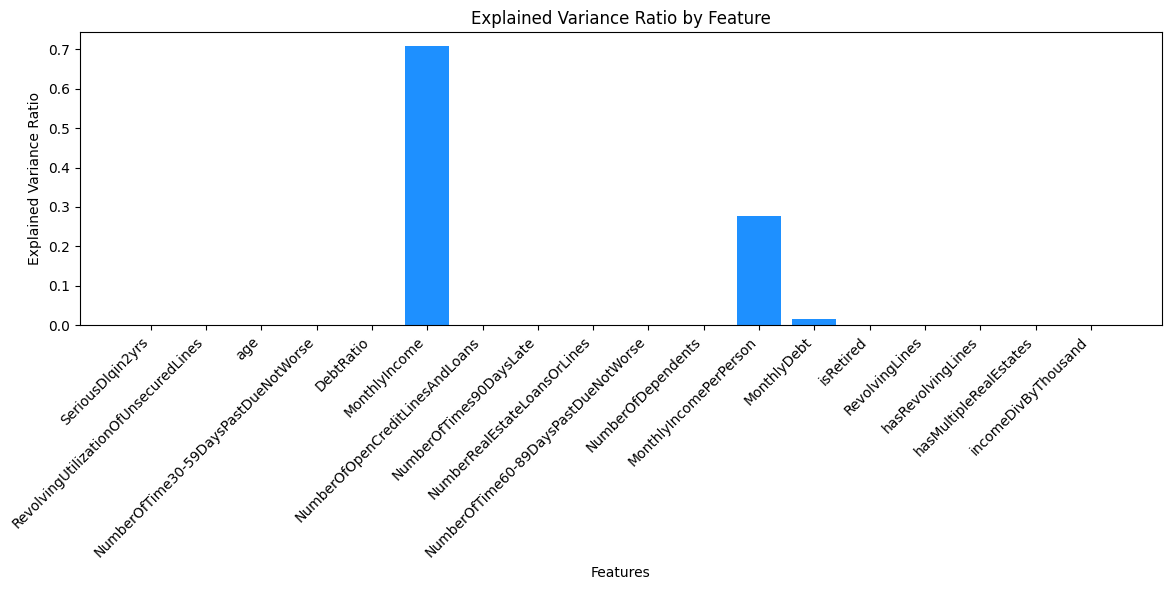

In [210]:
# Exclude non-informative features
features_to_exclude = ['Unnamed: 0']  # Add other non-predictive or index features here
features = [col for col in df.columns if col not in features_to_exclude]

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df[features])

# Calculate variance of each feature in the scaled dataset
feature_variances = np.var(X_imputed, axis=0)
total_variance = np.sum(feature_variances)

# Calculate explained variance ratio for each feature
explained_variance_ratio = feature_variances / total_variance

# Create a DataFrame to display the explained variance ratio for each feature
explained_variance_df = pd.DataFrame({
    "Feature": features,
    "Explained Variance Ratio": explained_variance_ratio
})

print(explained_variance_df)

# Plotting the explained variance ratio
plt.figure(figsize=(12, 6))
plt.bar(explained_variance_df['Feature'], explained_variance_df['Explained Variance Ratio'], color='dodgerblue')
plt.xlabel('Features')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

From that it's clear for us that we can apply the PCA over 3 Principal Components: MonthlyIncome (i.e., the most explanatory), MonthlyIncomePerPerson and MonthlyDebt.
Let's proceed:


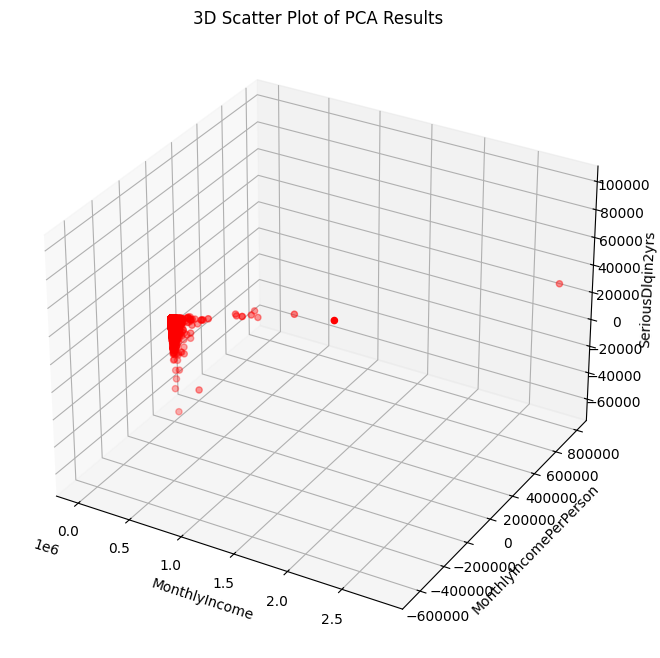

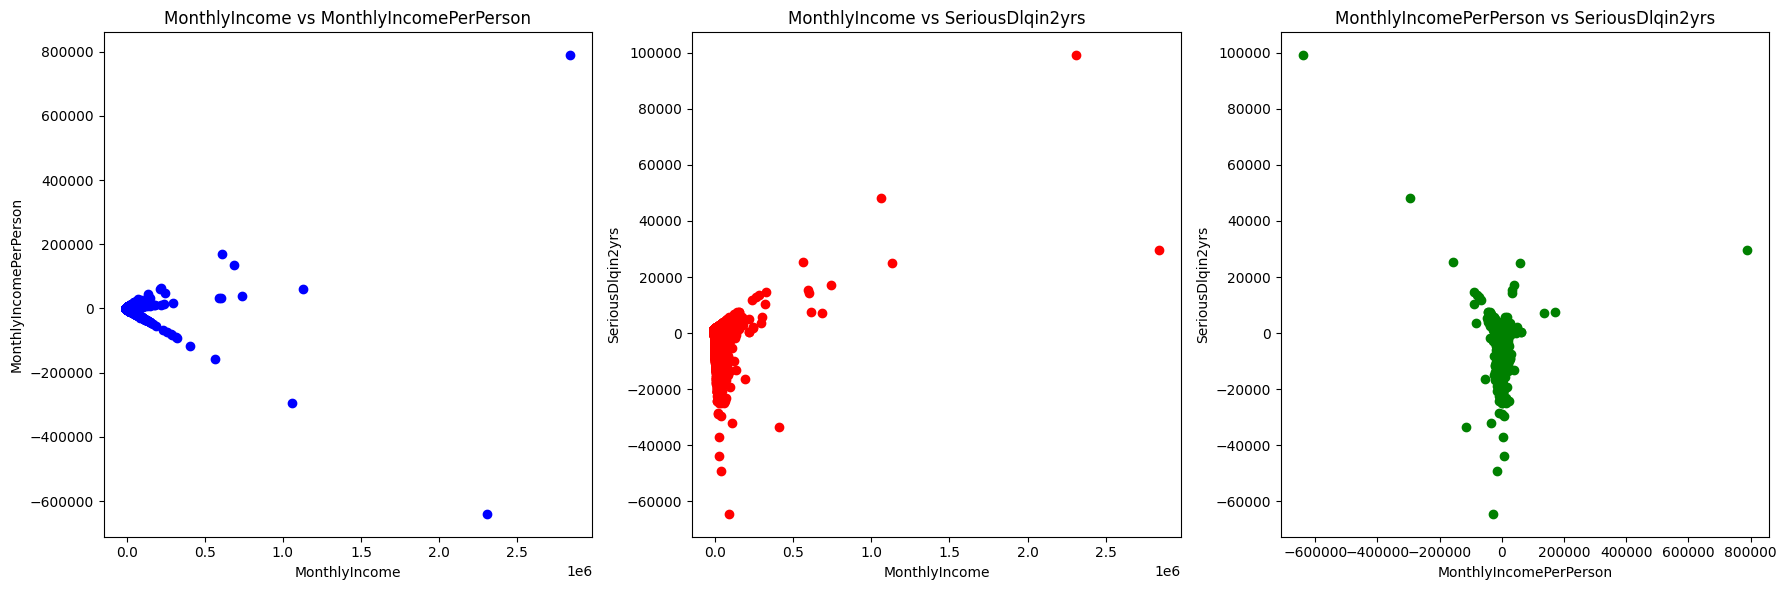

Explained Variance Ratios:
MonthlyIncome: 90.97%
MonthlyIncomePerPerson: 7.54%
SeriousDlqin2yrs: 1.49%


In [211]:
from sklearn.decomposition import PCA

# Applying PCA for the 3 principal components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_imputed)

# Explained variance ratio for the 3 components
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the results in a 3D scatter plot with custom labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='r', marker='o')
ax.set_xlabel('MonthlyIncome')
ax.set_ylabel('MonthlyIncomePerPerson')
ax.set_zlabel('SeriousDlqin2yrs')
plt.title('3D Scatter Plot of PCA Results')
plt.show()

# Plotting the results in 2D scatter plots for each pair of components with custom labels
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o')
axs[0].set_xlabel('MonthlyIncome')
axs[0].set_ylabel('MonthlyIncomePerPerson')
axs[0].set_title('MonthlyIncome vs MonthlyIncomePerPerson')

axs[1].scatter(X_pca[:, 0], X_pca[:, 2], c='red', marker='o')
axs[1].set_xlabel('MonthlyIncome')
axs[1].set_ylabel('SeriousDlqin2yrs')
axs[1].set_title('MonthlyIncome vs SeriousDlqin2yrs')

axs[2].scatter(X_pca[:, 1], X_pca[:, 2], c='green', marker='o')
axs[2].set_xlabel('MonthlyIncomePerPerson')
axs[2].set_ylabel('SeriousDlqin2yrs')
axs[2].set_title('MonthlyIncomePerPerson vs SeriousDlqin2yrs')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

# Print the explained variance ratio for the 3 principal components with custom labels
print("Explained Variance Ratios:")
print("MonthlyIncome: {:.2%}".format(explained_variance_ratio[0]))
print("MonthlyIncomePerPerson: {:.2%}".format(explained_variance_ratio[1]))
print("SeriousDlqin2yrs: {:.2%}".format(explained_variance_ratio[2]))

Then we have completed the PCA. The PCA visualizations reveal that most of the dataset clusters at lower income and debt levels, with outliers primarily evident in MonthlyIncome and MonthlyIncomePerPerson. The clustering indicates common financial behaviors among the majority, while the outliers suggest variations that warrant further investigation. These patterns imply potential areas of interest for deeper financial analysis or customer segmentation, particularly focusing on those outlier cases where income and debt behaviors diverge significantly from the norm.

Now we go forward by creating the dataframe of PCA to subsequently evaluate the models in the following section **'Model Testing'**

In [107]:
df_PCA = pd.DataFrame(data=X_pca, columns=['MonthlyIncome', 'MonthlyIncomePerPerson', 'SeriousDlqin2yrs'])

# Evaluation Framework

### Tuning Function

In [212]:
# Import some useful models:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

We define a tuning function to choose the best paramaters when we are doing the model testing of the XGBoost:

In [213]:
# Ignore warnings
warnings.filterwarnings('ignore')

def tune(X, y, space, scoring, 
         model, modeltype='clf', search_type='grid', n_iter_random=100,
         n_splits=5, n_repeats=3, random_state=1,
         verbose=True, display_plots=False, refit=None):
    """
    Tune hyperparameters of a machine learning model using grid search or random search.

    Parameters:
    - X (array-like): The input features.
    - y (array-like): The target variable.
    - space (dict): The hyperparameter space to search over.
    - scoring (str or callable): The scoring metric to optimize.
    - model (estimator): The machine learning model to tune.
    - modeltype (str, optional): The type of model ('clf' for classification, 'reg' for regression). Defaults to 'clf'.
    - search_type (str, optional): The type of search ('grid' for grid search, 'random' for random search). Defaults to 'grid'.
    - n_iter_random (int, optional): The number of iterations for random search. Defaults to 100.
    - n_splits (int, optional): The number of splits for cross-validation. Defaults to 5.
    - n_repeats (int, optional): The number of repeats for cross-validation. Defaults to 3.
    - random_state (int, optional): The random state for reproducibility. Defaults to 1.
    - verbose (bool, optional): Whether to display progress messages. Defaults to True.
    - display_plots (bool, optional): Whether to display plots of the search results. Defaults to False.
    - refit (str or callable, optional): The metric to use for refitting the best model. Defaults to None.

    Returns:
    - best_params (dict): The best hyperparameters found during the search.
    - best_model (estimator): The best model found during the search.
    """

    # Define evaluation
    if modeltype == 'clf':
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        if type(refit) is type(None):
            refit = 'AUC'
    elif modeltype == 'reg':
        cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        if type(refit) is type(None):
            refit = 'neg_mean_squared_error'
  
    if verbose:
        verbosity = 1

    # Define search
    if search_type == 'grid':
        search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv, verbose=verbosity, refit=refit)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv, n_iter=n_iter_random, verbose=verbosity, refit=refit)
    
    # Execute search
    result = search.fit(X, y)
    
    # Plot results
    if display_plots:
        results_df = pd.DataFrame(result.cv_results_)
        for key, values in space.items():
            
            # group the results by the hyperparameter
            param_means = []
            param_stds = []
            for value in values:
                mask = results_df['param_' + key] == value
                param_means.append(np.mean(results_df[mask]['mean_test_score']))
                param_stds.append(np.std(results_df[mask]['mean_test_score']))
            
            # create plot with two subplots side by side
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            fig.suptitle(key)
            ax[0].plot(values, param_means)
            ax[0].set_title('Mean test scores')
            ax[0].set_xlabel(key)
            ax[0].set_ylabel('mean scores')
            padding = 0.1
            ax[0].set_ylim(max(0, min(param_means) - padding), min(1, max(param_means) + padding))

            ax[1].plot(values, param_stds)
            ax[1].set_title('Mean score std')
            ax[1].set_xlabel(key)
            ax[1].set_ylabel('score std')
            padding = 0.05
            ax[1].set_ylim(max(0, min(param_stds) - padding), min(1, max(param_stds) + padding))

            plt.show()

    # Summarize result
    if verbose:
        # ANSI escape code for bold text
        bold = "\033[1m"
        # Reset ANSI escape code
        reset = "\033[0m"
        # Print the best score in bold
        print('')
        print('Best Score: %s%s%s' % (bold, result.best_score_, reset))
        print('Best Hyperparameters:')
        for k, v in result.best_params_.items():
            print('%s: %s' % (k, v))
        print('')

    # Best model
    best_model = result.best_estimator_

    return result.best_params_, best_model

### Test functions for performance

To be able to rapidly test our models and datasets and see how they compare against each other, we developed a tester program that automatically runs k-fold cross-validation on scikit models accross different datasets

We now define a class that will be helpful in evaluating the models:

In [214]:
class Tester():
    def __init__(self, target):
        self.target = target
        self.datasets = {}
        self.models = {}
        self.cache = {}

    def addDataset(self, name, df):
        self.datasets[name] = df.copy()

    def addModel(self, name, model):
        self.models[name] = model

    def clearModels(self):
        self.models = {}

    def clearCache(self):
        self.cache = {}

    def testModelWithDataset(self, m_name, df_name, sample_len, cv):
        if (m_name, df_name, sample_len, cv) in self.cache:
            return self.cache[(m_name, df_name, sample_len, cv)]

        clf = self.models[m_name]
        df = self.datasets[df_name]

        # Check if the dataset is empty
        if df.empty:
            raise ValueError(f"The dataset '{df_name}' is empty.")

        # Sample only if sample_len is specified
        if sample_len:
            sample_len = min(sample_len, len(df))
            sample = df.sample(sample_len)
        else:
            sample = df

        X = sample.drop([self.target], axis=1)
        Y = sample[self.target]

        s = cross_validate(clf, X, Y, scoring=['roc_auc'], cv=cv, n_jobs=-1)
        self.cache[(m_name, df_name, sample_len, cv)] = s

        return s

    def runTests(self, sample_len=None, cv=4):
        scores = {}
        for m_name in self.models:
            for df_name in self.datasets:
                start = time.time()
                try:
                    df_len = len(self.datasets[df_name])
                    if sample_len is None:
                        current_sample_len = df_len
                    else:
                        current_sample_len = min(sample_len, df_len)
                    score = self.testModelWithDataset(m_name, df_name, current_sample_len, cv)
                    scores[(m_name, df_name)] = score
                    end = time.time()
                    print(f"Tested {m_name} on {df_name} -- Time: {end - start:.2f}s")
                except ValueError as e:
                    print(f"Skipping {m_name} on {df_name} due to error: {e}")

        print('--- Top 10 Results ---')
        sorted_scores = sorted(scores.items(), key=lambda x: -1 * x[1]['test_roc_auc'].mean())[:10]
        for score in sorted_scores:
            auc = score[1]['test_roc_auc']
            print(f"{score[0]} --> AUC: {auc.mean():.4f} (+/- {auc.std():.4f})")

        return sorted_scores


In [215]:
# Create the two vectors
X = df.drop('SeriousDlqin2yrs', axis=1)  
y = df['SeriousDlqin2yrs']               

Now that we have this tester up and running, let's go back to the datasets we created in our data exploration section. We can easily add them to the tester program to see how our models perform on them.

In [216]:
df = df.apply(pd.to_numeric, errors='coerce')

In [217]:
# Create an instance of the Tester class with the target column specified
tester = Tester('SeriousDlqin2yrs')
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)
tester.addDataset('PCA dataset', df_PCA)
tester.addDataset('Feature Engineered Data', df_FEATENG)

# tester.runTests()

We noticed that the modified datasets have a big influence on the SVM AUC scores, but they don't affect the Random Forests as much. However, there's a noticeable gain in performance between simply dropping the missing values and the modified datasets accross all models. 

In [218]:
# check that the tester has all the data
i = 0
for el in tester.datasets:
    i += 1
    print(f'{i}     {el}')

1     Median Fill
2     Median Fill, Outliers Removed
3     Removed 98s
4     Removed utilization outliers
5     PCA dataset
6     Feature Engineered Data


# Model Testing

### L1 Regularized Logistic Regression

After having improvable results with the vanilla Logistic Regression (i.e. ROC AUC:**0.66**); we have decided to implement a L1 Regularized Logistic regression which is:

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best C: {'classifier__C': 0.001}
Confusion Matrix:
[[20753   150]
 [ 1340   197]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     20903
         1.0       0.57      0.13      0.21      1537

    accuracy                           0.93     22440
   macro avg       0.75      0.56      0.59     22440
weighted avg       0.91      0.93      0.91     22440

ROC AUC Score: 0.8449590451118967


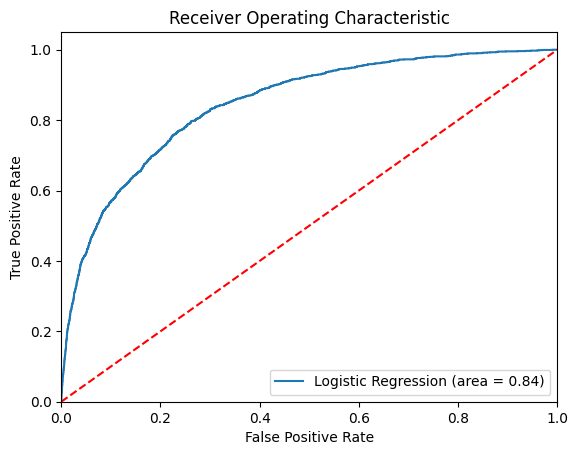

In [219]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Imputation, feature scaling, and logistic regression
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2', random_state=42))
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Parameters of the model
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Range of C values to try
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Best model found
best_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Best C:", grid_search.best_params_)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The results seems quite good with this regularizer: the AUC **0.84** is good but we have more interesting findings with other methods, then we can move forward.

### Random Forests

#### Elbow method

Now we implement the Elbow method to study the parameters to fit in the Random Forest:

Import of some specific libraries:

In [116]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

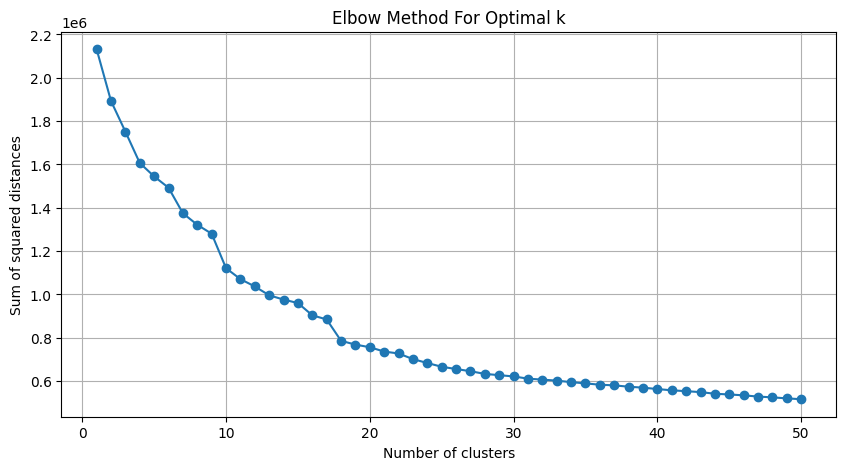

In [220]:
# Select numerical columns only
numerical_columns = df.select_dtypes(include=[np.number]).columns
X = df[numerical_columns]

# Handling missing values
X = X.fillna(X.median())

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate the sum of squared distances
ssd = []
for num_clusters in range(1, 51):  # Reduced range for testing
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)

# Plotting the results using the elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), ssd, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

Given the results of the Elbow method to evaluate which parameters choose in the Random Forest, then we choose an interval [20,40]

Random Forests seemed to be the best bet, so we decided to move forward with them and figure out the best tuning parameters. Running two for-loops allowed us to find the best value for max_depth and number of estimators, with our best model being the random forest with a depth of 9 and 16 estimators. When we use the data set that removes the RUUL outliers, it gives us an AUC of **.8612**. 

In [118]:
# Vanilla
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

# Now you can split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to hold models and their names
models = {}

# Iterate over a range of 'max_depth' and 'n_estimators' to generate different RandomForest models
for depth in range(5, 10):
    for n_estimators in range(20, 35):
        model_name = f"Random Forest - Depth: {depth}, Estimators: {n_estimators}"
        models[model_name] = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=0)

# Assuming 'tester' is an instance of the Tester class
tester = Tester('SeriousDlqin2yrs')

# Adding the datasets to the tester
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)

# Add models to the tester
for name, model in models.items():
    tester.addModel(name, model)

# Run all tests (fit and evaluate the models)
results = tester.runTests()

# Display results
for result in results:
    (model_name, dataset_name), score = result
    auc = score['test_roc_auc']
    print(f"{model_name}, {dataset_name}: AUC = {auc.mean():.4f} (+/- {auc.std():.4f})")

Tested Random Forest - Depth: 5, Estimators: 20 on Median Fill -- Time: 2.80s
Tested Random Forest - Depth: 5, Estimators: 20 on Median Fill, Outliers Removed -- Time: 2.56s
Tested Random Forest - Depth: 5, Estimators: 20 on Removed 98s -- Time: 1.70s
Tested Random Forest - Depth: 5, Estimators: 20 on Removed utilization outliers -- Time: 1.57s
Tested Random Forest - Depth: 5, Estimators: 21 on Median Fill -- Time: 1.96s
Tested Random Forest - Depth: 5, Estimators: 21 on Median Fill, Outliers Removed -- Time: 1.70s
Tested Random Forest - Depth: 5, Estimators: 21 on Removed 98s -- Time: 1.58s
Tested Random Forest - Depth: 5, Estimators: 21 on Removed utilization outliers -- Time: 1.77s
Tested Random Forest - Depth: 5, Estimators: 22 on Median Fill -- Time: 1.77s
Tested Random Forest - Depth: 5, Estimators: 22 on Median Fill, Outliers Removed -- Time: 1.73s
Tested Random Forest - Depth: 5, Estimators: 22 on Removed 98s -- Time: 1.74s
Tested Random Forest - Depth: 5, Estimators: 22 on Rem

KeyboardInterrupt: 

Now we try to run the **Random Forest** with our PCA results:

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df_PCA.drop('SeriousDlqin2yrs', axis=1)
y = df_PCA['SeriousDlqin2yrs']

# Now you can split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to hold models and their names
models = {}

# Iterate over a range of 'max_depth' and 'n_estimators' to generate different RandomForest models
for depth in range(5, 10):
    for n_estimators in range(20, 35):
        model_name = f"Random Forest - Depth: {depth}, Estimators: {n_estimators}"
        models[model_name] = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=0)

# Assuming 'tester' is an instance of the Tester class
tester = Tester('SeriousDlqin2yrs')

# Adding the datasets to the tester
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)

# Add models to the tester
for name, model in models.items():
    tester.addModel(name, model)

# Run all tests (fit and evaluate the models)
results = tester.runTests()

# Display results
for result in results:
    (model_name, dataset_name), score = result
    auc = score['test_roc_auc']
    print(f"{model_name}, {dataset_name}: AUC = {auc.mean():.4f} (+/- {auc.std():.4f})")

Tested Random Forest - Depth: 5, Estimators: 20 on Median Fill -- Time: 2.77s
Tested Random Forest - Depth: 5, Estimators: 20 on Median Fill, Outliers Removed -- Time: 2.07s
Tested Random Forest - Depth: 5, Estimators: 20 on Removed 98s -- Time: 2.19s
Tested Random Forest - Depth: 5, Estimators: 20 on Removed utilization outliers -- Time: 1.83s
Tested Random Forest - Depth: 5, Estimators: 21 on Median Fill -- Time: 2.54s
Tested Random Forest - Depth: 5, Estimators: 21 on Median Fill, Outliers Removed -- Time: 1.82s


KeyboardInterrupt: 

It turns out that the ROC AUC performance is now *0.8614* which is slightly better than our previous result.
Then effectively the PCA has some kind of improvements, and we have positive results, even if it's not a tremendous improvements; but since we are at high score of explanatory capacity, it is a very positive result.

Now we try this model even for the dataframe which we have obtained from our Feature Engineering:

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df_FEATENG.drop('SeriousDlqin2yrs', axis=1)
y = df_FEATENG['SeriousDlqin2yrs']

# Now you can split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to hold models and their names
models = {}

# Iterate over a range of 'max_depth' and 'n_estimators' to generate different RandomForest models
for depth in range(5, 10):
    for n_estimators in range(20, 35):
        model_name = f"Random Forest - Depth: {depth}, Estimators: {n_estimators}"
        models[model_name] = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=0)

# Assuming 'tester' is an instance of the Tester class
tester = Tester('SeriousDlqin2yrs')

# Adding the datasets to the tester
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)

# Add models to the tester
for name, model in models.items():
    tester.addModel(name, model)

# Run all tests (fit and evaluate the models)
results = tester.runTests()

# Display results
for result in results:
    (model_name, dataset_name), score = result
    auc = score['test_roc_auc']
    print(f"{model_name}, {dataset_name}: AUC = {auc.mean():.4f} (+/- {auc.std():.4f})")

Tested Random Forest - Depth: 5, Estimators: 20 on Median Fill -- Time: 2.66s
Tested Random Forest - Depth: 5, Estimators: 20 on Median Fill, Outliers Removed -- Time: 2.08s
Tested Random Forest - Depth: 5, Estimators: 20 on Removed 98s -- Time: 1.97s
Tested Random Forest - Depth: 5, Estimators: 20 on Removed utilization outliers -- Time: 1.59s
Tested Random Forest - Depth: 5, Estimators: 21 on Median Fill -- Time: 1.62s
Tested Random Forest - Depth: 5, Estimators: 21 on Median Fill, Outliers Removed -- Time: 1.61s
Tested Random Forest - Depth: 5, Estimators: 21 on Removed 98s -- Time: 1.76s
Tested Random Forest - Depth: 5, Estimators: 21 on Removed utilization outliers -- Time: 1.84s
Tested Random Forest - Depth: 5, Estimators: 22 on Median Fill -- Time: 1.74s
Tested Random Forest - Depth: 5, Estimators: 22 on Median Fill, Outliers Removed -- Time: 1.79s
Tested Random Forest - Depth: 5, Estimators: 22 on Removed 98s -- Time: 1.70s
Tested Random Forest - Depth: 5, Estimators: 22 on Rem

KeyboardInterrupt: 

It seems that Feature Engineering works quite well with Random Forest; althought the improvement seems to be less effective than PCA, then we discard it for our final prediction.

This is a Tester defined function which shows us the datasets:

In [121]:
tester.datasets

{'Median Fill':         Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
 0                0               0.0                              0.034949   
 1                1               0.0                              0.155308   
 2                2               0.0                              0.165166   
 3                3               0.0                              0.010886   
 4                4               0.0                              0.000717   
 ...            ...               ...                                   ...   
 112495      112495               0.0                              0.008277   
 112496      112496               0.0                              0.054864   
 112497      112497               1.0                              0.209912   
 112498      112498               0.0                              0.004995   
 112499      112499               0.0                              0.657152   
 
          age  NumberOfTime30-59Day

### K-Nearest Neighbors

We were also curious to see how a simpler learner would perform, so we tested a simple K-Nearest Neighbors model. Unsurprisingly, the results were not that great:

In [221]:
from sklearn.neighbors import KNeighborsClassifier

X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Apply the imputer to our resampled data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)  

# Create a K-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9285650623885918
Precision: 0.17
Recall: 0.011060507482108002
F1 Score: 0.020769700671960906
Confusion Matrix:
[[20820    83]
 [ 1520    17]]


### XGBoost

We import the libraries necessary for the XGBoost performance:

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier

Thanks to tuning of parameters of previously defined function, we perform the XGBoost on our dataset df:

In [223]:
data_to_use = df

X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


# define the space of hyperparameters to search for xgboost
param_space = {
    'n_estimators': [150],
    'max_depth': [2, 3, 5],
    'gamma': [0],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'colsample_bylevel': [0.6, 0.8, 1],
    'scale_pos_weight': [scale_pos_weight],
    'objective': ['binary:logistic'],
}
model = XGBClassifier()

# define a multi metric to use in the tuning
scoring = {
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'F1': 'f1',
    'Precision': 'precision',
    'Recall': 'recall'
}

# tune the model
best_params, best_model = tune(X=X_train, y=y_train, space=param_space, 
                               model=model, search_type='grid', n_iter_random=120, 
                               n_splits=5, n_repeats=1, scoring=scoring)


# evaluate on the test set
y_pred = best_model.predict(X_test)

# print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Confusion matrix: {confusion_matrix(y_test, y_pred)}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best Score: 0.8644987165020342
Best Hyperparameters:
colsample_bylevel: 0.8
colsample_bytree: 0.6
gamma: 0
learning_rate: 0.1
max_depth: 3
n_estimators: 150
objective: binary:logistic
scale_pos_weight: 14.042232277526395
subsample: 1

Accuracy: 0.795187165775401
ROC AUC: 0.7785496853499126
F1 score: 0.3367965367965368
Precision: 0.21639161876506582
Recall: 0.7592713077423552
Confusion matrix: [[16677  4226]
 [  370  1167]]


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])
average_precision = average_precision_score(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Feature Importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

**ROC Curve:** The area under the curve (AUC) can help you understand the overall accuracy of the model across all classification thresholds.\
**Precision-Recall Curve:** Particularly useful when classes are very imbalanced.\
**Confusion Matrix:** Provides a visualization of true positives, false positives, true negatives, and false negatives.\
**Feature Importance:** Helps in understanding which features contribute most to the model predictions.

Then, we want to exploit also how the feature engineering works with XGBoost: 

In [230]:
data_to_use = df_FEATENG

# split the data into train and test
X_train, X_val, y_train, y_val = train_test_split(data_to_use.drop('SeriousDlqin2yrs', axis=1), data_to_use['SeriousDlqin2yrs'], test_size=0.2, random_state=42)

# Calculate the class weights safely
class_counts = y_train.value_counts()
majority_class_count = class_counts.get(0, 0)  
minority_class_count = class_counts.get(1, 0)  

# Ensure there is no division by zero
if minority_class_count == 0:
    scale_pos_weight = 1  # or another suitable default, like a small positive number
else:
    scale_pos_weight = majority_class_count / minority_class_count

# Define the space of hyperparameters to search for xgboost
param_space = {
    'n_estimators': [150],
    'max_depth': [2, 3, 5],
    'gamma': [0],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'colsample_bylevel': [0.6, 0.8, 1],
    'scale_pos_weight': [scale_pos_weight],
    'objective': ['binary:logistic'],
}
model = XGBClassifier()

# define a multi metric to use in the tuning
scoring = {
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'F1': 'f1',
    'Precision': 'precision',
    'Recall': 'recall'
}

# tune the model
best_params, best_model_= tune(X=X_train, y=y_train, space=param_space, 
                               model=model, search_type='grid', n_iter_random=120, 
                               n_splits=5, n_repeats=1, scoring=scoring)


# evaluate on the test set
y_pred = best_model.predict(X_val)

# print the evaluation metrics
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_val, y_pred)}')
print(f'F1 score: {f1_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Confusion matrix: {confusion_matrix(y_val, y_pred)}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x13ce019d0>>
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


KeyboardInterrupt: 

The result is very high: **0.8647**; our experiment of Feature Engineering seems to be good, and seems to make sense with an appropiate tuning of parameters

### Neural Network

In [127]:
# Import useful models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [128]:
#Prepare and scale the data
X = df.drop('SeriousDlqin2yrs', axis=1).values
y = df['SeriousDlqin2yrs'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [233]:
# Define the neural network architecture
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/50
2763/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.9298 - loss: nan

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 12, but received input with shape (None, 18)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 18), dtype=float32)
  • training=False
  • mask=None

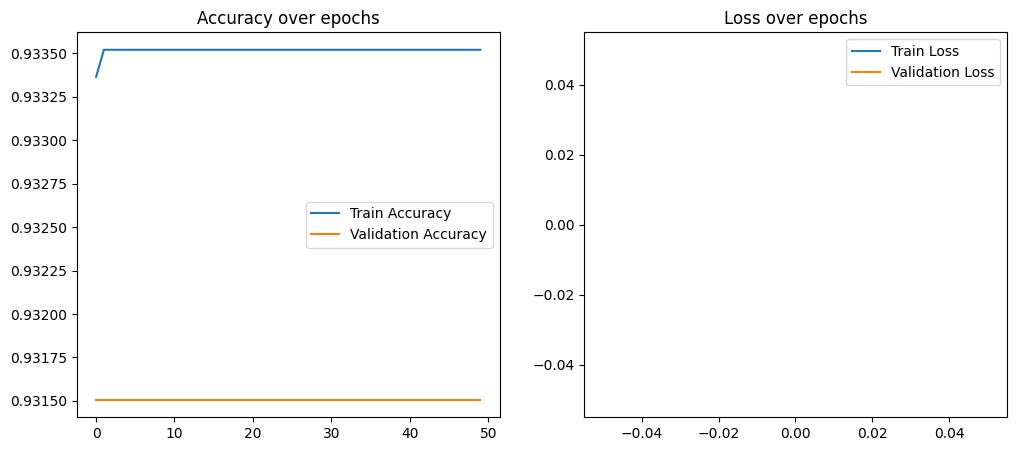

In [ ]:
# Plot accuracy and loss of the model 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()

In [ ]:
# Generate predictions
predictions = model.predict(X_valid)
predicted_classes = (predictions > 0.5).astype(int)

# Check if all predictions are the same
if np.unique(predicted_classes).size == 1:
    print("All predictions are the same.")
else:
    print("Diverse predictions.")


702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
All predictions are the same.


In [ ]:
#### Evaluate the model using additional metrics
from sklearn.metrics import classification_report, roc_auc_score

y_pred = (model.predict(X_valid) > 0.5).astype(int)
print(classification_report(y_valid, y_pred))
print("ROC AUC Score:", roc_auc_score(y_valid, y_pred))

702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     20903
         1.0       0.00      0.00      0.00      1537

    accuracy                           0.93     22440
   macro avg       0.47      0.50      0.48     22440
weighted avg       0.87      0.93      0.90     22440

ROC AUC Score: 0.5


The model exhibits high accuracy, both in training and validation, yet it consistently predicts the same class regardless of input, indicating a simplistic decision boundary. A closer look at the classification report reveals significant class imbalance, with Class 0 dominating with 20903 instances compared to Class 1's 1537. This imbalance heavily skews evaluation metrics, making the model appear high-performing, especially considering the misleadingly high accuracy of 93%. Moreover, the ROC AUC score of 0.5 suggests the model's inability to discriminate between positive and negative instances, indicating poor performance beyond mere accuracy. Addressing class imbalance is paramount to improving the model's ability to identify minority class instances effectively.

#### NN using resampling

We perform 4 resampling methods: 2 undersampling and 2 oversampling methods. Look at the paper the selection criteria behind the 4 methods. 

In [ ]:
# Create an imputer object with a median filling strategy to remove NaNs
imputer = SimpleImputer(strategy='median')

# Apply the imputer to our resampled data
X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)  

In [ ]:
#Random Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Define RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Perform undersampling
X_train_random, y_train_random = undersampler.fit_resample(X_train, y_train)

In [ ]:
#NearMiss Undersampling
from imblearn.under_sampling import NearMiss

# Define NearMiss undersampler
undersampler = NearMiss(version=1)

# Perform undersampling
X_train_nearmiss, y_train_nearmiss = undersampler.fit_resample(X_train, y_train)


In [ ]:
#SMOTE Oversampling
from imblearn.over_sampling import SMOTE

# Define SMOTE oversampler
oversampler = SMOTE(random_state=42)

# Perform oversampling
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

In [ ]:
#ADASYN oversampler
from imblearn.over_sampling import ADASYN

# Define ADASYN oversampler
oversampler = ADASYN(random_state=42)

# Perform oversampling
X_train_adasyn, y_train_adasyn = oversampler.fit_resample(X_train, y_train)


In [ ]:
dataset = {
    'X_train_random': X_train_random,
    'y_train_random': y_train_random,
    'X_train_nearmiss': X_train_nearmiss,
    'y_train_nearmiss': y_train_nearmiss,
    'X_train_smote': X_train_smote,
    'y_train_smote': y_train_smote,
    'X_train_adasyn': X_train_adasyn,
    'y_train_adasyn': y_train_adasyn
}

In [ ]:
#Lists to store metrics for each resampling method
history_dict={}
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs =[]

# Iterate over the resampling methods and train the model for each
for resampling_method in ['random', 'nearmiss', 'smote', 'adasyn']:
    X_train_resampled = dataset[f'X_train_{resampling_method}']
    y_train_resampled = dataset[f'y_train_{resampling_method}']

    print(f"Training model with {resampling_method} resampling")

    # Define the neural network architecture
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_valid, y_valid))
    history_dict[resampling_method] = history

    # Predict on the validation set
    y_pred = (model.predict(X_valid) > 0.5).astype("int32")

    # Calculate metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)

    # Print metrics
    print(f"Validation accuracy with {resampling_method} resampling: {accuracy}")
    print(f"Precision with {resampling_method} resampling: {precision}")
    print(f"Recall with {resampling_method} resampling: {recall}")
    print(f"F1 Score with {resampling_method} resampling: {f1}")
    print(f"F1 Score with {resampling_method} resampling: {roc_auc}")
    print()

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

# Print the recorded metrics for all resampling methods
print("Accuracies for all resampling methods:", accuracies)
print("Precisions for all resampling methods:", precisions)
print("Recalls for all resampling methods:", recalls)
print("F1 Scores for all resampling methods:", f1_scores)
print("ROC AUC Scores for all resampling methods:", roc_aucs)

# Plotting
plt.figure(figsize=(20, 10))
for i, (key, history) in enumerate(history_dict.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy over epochs using {key}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

Training model with random resampling
Epoch 1/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7363 - loss: 0.5377 - val_accuracy: 0.7511 - val_loss: 0.5033
Epoch 2/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.7736 - loss: 0.4787 - val_accuracy: 0.7614 - val_loss: 0.4868
Epoch 3/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.7850 - loss: 0.4617 - val_accuracy: 0.7970 - val_loss: 0.4393
Epoch 4/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7815 - loss: 0.4647 - val_accuracy: 0.7807 - val_loss: 0.4615
Epoch 5/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7865 - loss: 0.4654 - val_accuracy: 0.7581 - val_loss: 0.5059
Epoch 6/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7876 - loss: 0.4590 - val_accuracy: 0.7785 - val_loss: 0.4719
Epoch 7/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7876 - loss: 0.4558 - val_accuracy: 0.7862 - val_loss: 0.4630
Epoch 8/50
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - 

Now that we have found our best model, we use the trained model with the Test Set to have the final submission CSV:

In [ ]:
# Load test data
df_test = pd.read_csv('data/test.csv', index_col=0)
df_test['income_dependent'] = df_test['MonthlyIncome'] / (df_test['NumberOfDependents'] + 1)
df_test['DelinquencyRatio'] = (df_test['NumberOfTime30-59DaysPastDueNotWorse'] + df_test['NumberOfTimes90DaysLate'] + df_test['NumberOfTime60-89DaysPastDueNotWorse']) / (df_test['NumberOfOpenCreditLinesAndLoans'] + 1)
# Assuming 'df' is the DataFrame from which you compute the median for imputation
# Replace 'df' with your actual DataFrame containing the training or full dataset to compute the correct median
test_imputed = df_test.fillna(df.median(numeric_only=True))

# Assuming 'model' is your trained XGBClassifier instance
# You need to load or define your trained model here if it's not already loaded
# For example:
# Predict probabilities
preds = best_model.predict_proba(test_imputed)[:, 1]  # Ensure 'model' is a trained instance of XGBClassifier

# Create a DataFrame of predictions
pred_df = pd.DataFrame(preds, columns=['SeriousDlqin2yrs'])
pred_df.to_csv('data/submission.csv', index=False)